In [25]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from scipy.stats import kstest
import numpy as np
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import powerlaw
from statsmodels.api import qqplot
from datetime import datetime, timedelta

import utils.processing_utils as pu
import utils.simulation_utils as su

In [2]:
save_figs = False

In [3]:
pu.batch_convert_db_contents(start_str="reddit-sim_qwen_pf1")

Connecting to reddit-sim_qwen_pf1-1h
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-1h/sp1/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-1h/sp3/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-1h/sp5/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-1h/sp4/
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-1h/sp2/
Connecting to reddit-sim_qwen_pf1-23h
Tables saved at /../abyss/home/oasis/oasis-rutschmanna/data/db_json/reddit-sim_qwen_pf1-23h/sp1/


***
# Generate Seed Personas

In [4]:
# Load final Oswald data
sample_data = pd.read_csv(
    "../../oswald-et-al_2025/sample_anon.csv"
)
print(len(sample_data))
print(sample_data["subreddit"].unique())

520
['DiscussPolitics5' 'DiscussPolitics1' 'DiscussPolitics4'
 'DiscussPolitics6' 'DiscussPolitics2' 'DiscussPolitics3']


In [5]:
# Use seed data to generate seed personas for llm agents
subreddit_personas = {}

for i in range(1, len(sample_data["subreddit"].unique()) + 1):
    subreddit_data = sample_data[sample_data["subreddit"] == f"DiscussPolitics{i}"]
    subreddit_personas[f"pf{i}"] = su.generate_personas(subreddit_data)

    with open(f"../data/reddit/pf{i}_personas.json", "w") as f:
        json.dump(subreddit_personas[f"pf{i}"], f, indent=4)

Missing Survey Info for user: 6805c12d7d
Missing Survey Info for user: fa8294833b
Missing Survey Info for user: 47d85e4818


In [6]:
# Print number of agents per subreddit
for i in range(1, len(sample_data["subreddit"].unique()) + 1):
    print(f"pf{i}:", len(subreddit_personas[f"pf{i}"]))

pf1: 80
pf2: 85
pf3: 85
pf4: 82
pf5: 85
pf6: 100


***
# Load Sim Data

In [7]:
data = pu.load_db_json_data(
    "/../abyss/home/oasis/oasis-rutschmanna/data/db_json/",
    "reddit-sim_qwen_pf1-16",
    to_df=True
)

for i in list(data.keys()):
    data[i]["n_agents"] = data[i]["persona_file"].map(
        subreddit_personas
    ).apply(len)

Reading:  reddit-sim_qwen_pf1-23h


In [8]:
structure_data = {}
for i in list(data.keys()):
    vol, width, depth, scale, active, comment_lengths = pu.structure_analysis(
        data[i]
    )
    structure_data[i] = {
        "volume" : vol,
        "width" : width,
        "depth" : depth,
        "scale" : scale,
        "active" : active,
        "comment_lengths" : comment_lengths
    }

In [9]:
t_df = data[list(data.keys())[0]]

***
# Structural Analysis

In [10]:
# Print avg. share of actives in SIM
temp = [[], []]
for i in list(structure_data.keys()):
    temp[0].append(structure_data[i]["scale"])
    temp[1].append(structure_data[i]["active"])

print("# Users:", np.mean(temp[0]))
print("% Users:", np.mean(temp[1]))

# Users: 47.0
% Users: 0.588


In [11]:
# Load User data and discussions data
seed_data = pd.read_csv("../../oswald-et-al_2025/pre_survey_anon.csv")

seed_data.drop_duplicates("ParticipantID", inplace=True)
seed_data = seed_data.loc[seed_data["on_reddit"] == 1]
print(len(seed_data))

discussions_data = pd.read_csv(
    "../../oswald-et-al_2025/discussions_anon.csv",
    index_col=0
)
discussions_data.dropna(subset="ParticipantID", inplace=True)
print(len(discussions_data))

# Group by participant and count number of submissions created during experiment
discussions_data["comment_count"] = discussions_data.groupby(
    "ParticipantID"
)["ParticipantID"].transform("count").map(int)

discussions_data_merge = discussions_data[[
    "ParticipantID", "comment_count"
]].drop_duplicates()

seed_data = seed_data.merge(discussions_data_merge,
                            how="left",on="ParticipantID")

seed_data.fillna({"comment_count" : 0}, inplace=True)
# Print total user # and share of actives
print(len(seed_data))
print(len(seed_data[seed_data["comment_count"] != 0]) / len(seed_data))

520
5792
520
0.6365384615384615


In [12]:
# Replace NAs with 0 for further analysis (0 comments, 0 likes, etc.)
sample_data = sample_data[[
    "ParticipantID",
    "subreddit",
    "polinterest",
    "time_online",
    "social_media",
    "comments_online",
    "comment_count",
    "comment_mean_lenght",
    "comment_mean_score",
    "comment_mean_tox"
]]

sample_data.rename(columns={"comment_mean_lenght":"comment_mean_length"},
                  inplace=True)

sample_data.fillna(0, inplace=True)
print(len(sample_data))

sample_sub_1_data = sample_data[sample_data["subreddit"] == "DiscussPolitics1"]

520


In [13]:
def process_plot_data(data, metric, cummulate=True):
    if cummulate:
        return [i for j in [i[metric] for i in data.values()] for i in j]
    else:
        return [i[metric] for i in data.values()]

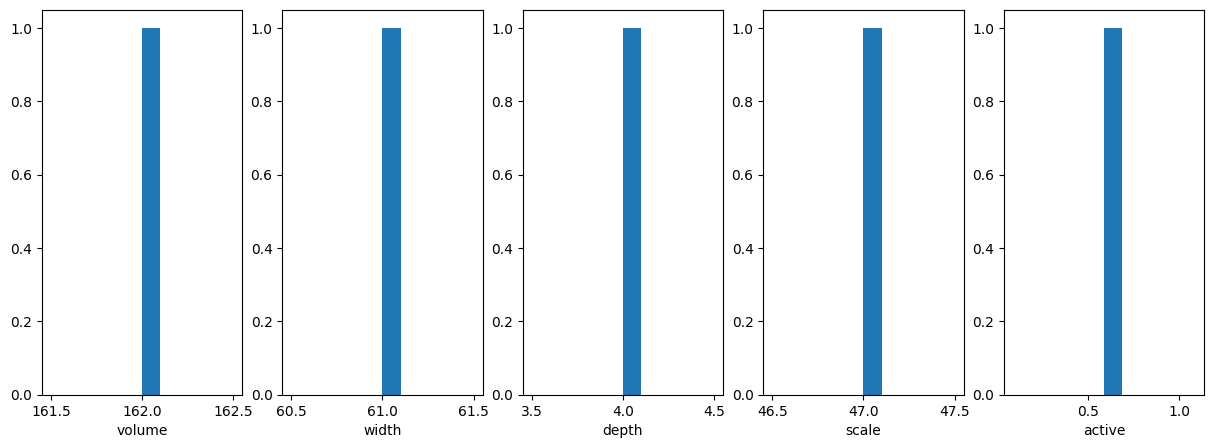

In [14]:
# Plot simulation descriptives
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].hist(process_plot_data(structure_data, "volume"))
axs[0].set_xlabel("volume")

axs[1].hist(process_plot_data(structure_data, "width"))
axs[1].set_xlabel("width")

axs[2].hist(process_plot_data(structure_data, "depth"))
axs[2].set_xlabel("depth")

axs[3].hist(process_plot_data(structure_data, "scale"))
axs[3].set_xlabel("scale")

axs[4].hist(process_plot_data(structure_data, "active"))
axs[4].set_xlabel("active")

if save_figs:
    plt.savefig("figures/sim_descriptives.jpg")
plt.show()

5792


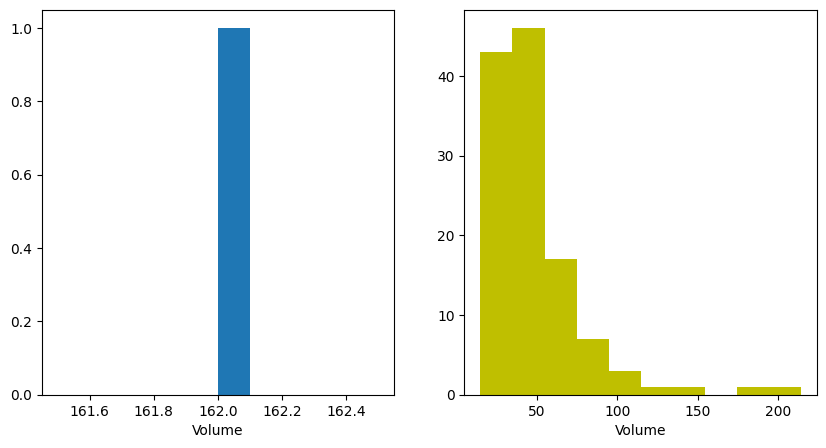

In [15]:
# Plot dist of volume across sim and seed threads
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(process_plot_data(structure_data, "volume"))
axs[0].set_xlabel("Volume")

temp = discussions_data.groupby(["subreddit", "post_title"]).count()["ParticipantID"]

print(discussions_data.groupby([
    "subreddit", "post_title"
]).count()["ParticipantID"].sum())

axs[1].hist(temp, color="y", label="Seed")
axs[1].set_xlabel("Volume")

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_vol.jpg")
plt.show()

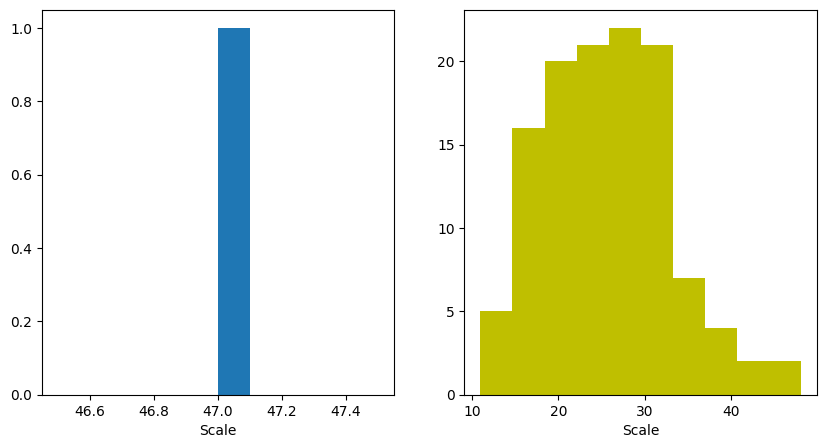

In [16]:
# Plot dist of scale across sim and seed threads
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(process_plot_data(structure_data, "scale"), label="SIM")
axs[0].set_xlabel("Scale")

temp = discussions_data.groupby([
    "subreddit", "post_title"
]).nunique("ParticipantID")

axs[1].hist(temp["ParticipantID"], color="y", label="Seed")
axs[1].set_xlabel("Scale")

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_dist_scale.jpg")
plt.show()

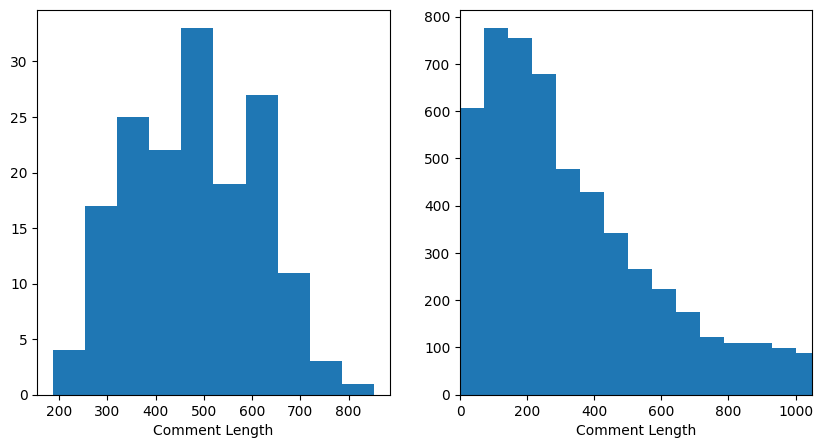

In [17]:
# Plot dist of comment lengths for all Sims
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist([i for j in process_plot_data(
    structure_data, "comment_lengths"
) for i in j],
           label="Sim")

axs[0].set_xlabel("Comment Length")

axs[1].hist(discussions_data["length_comment_char"], bins=100, label="Seed")
axs[1].set_xlabel("Comment Length")
axs[1].set_xlim(0, 1050)

# plt.legend()
if save_figs:
    plt.savefig("figures/seed-sim_dist_comment-lengths.jpg")
plt.show()

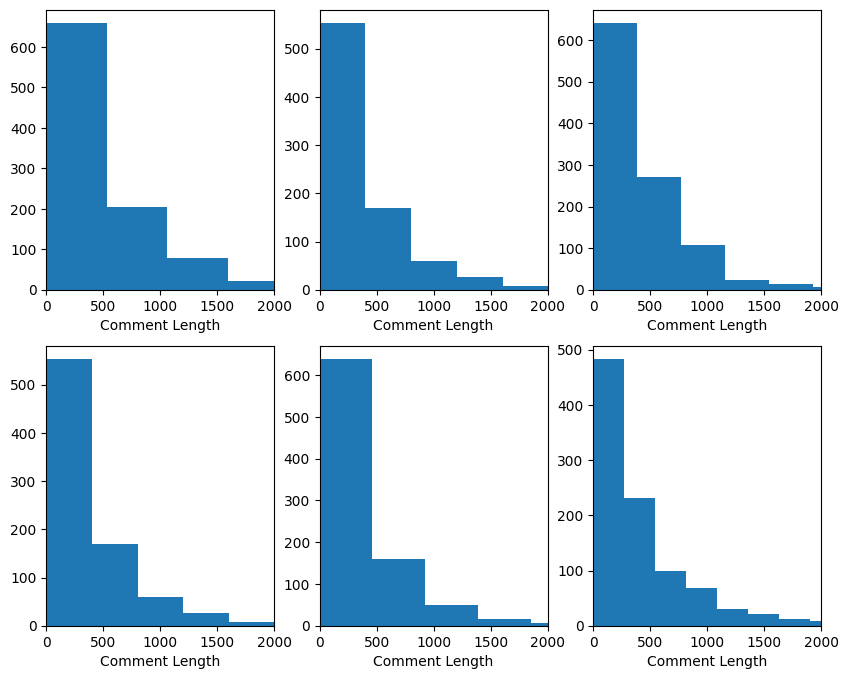

In [18]:
# Plot dist of comment lengths for all Sims
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

for i in range(2):
    for j in range(3):
        temp = discussions_data.loc[discussions_data["subreddit"] == f"DiscussPolitics{(i+1)*(j+1)}"]
        axs[i][j].hist(
            temp["length_comment_char"], label="Seed"
        )
        axs[i][j].set_xlabel("Comment Length")
        axs[i][j].set_xlim(0, 2000)

# plt.legend()
if save_figs:
    plt.savefig("figures/seed_dist_sub-comment-lengths.jpg")
plt.show()

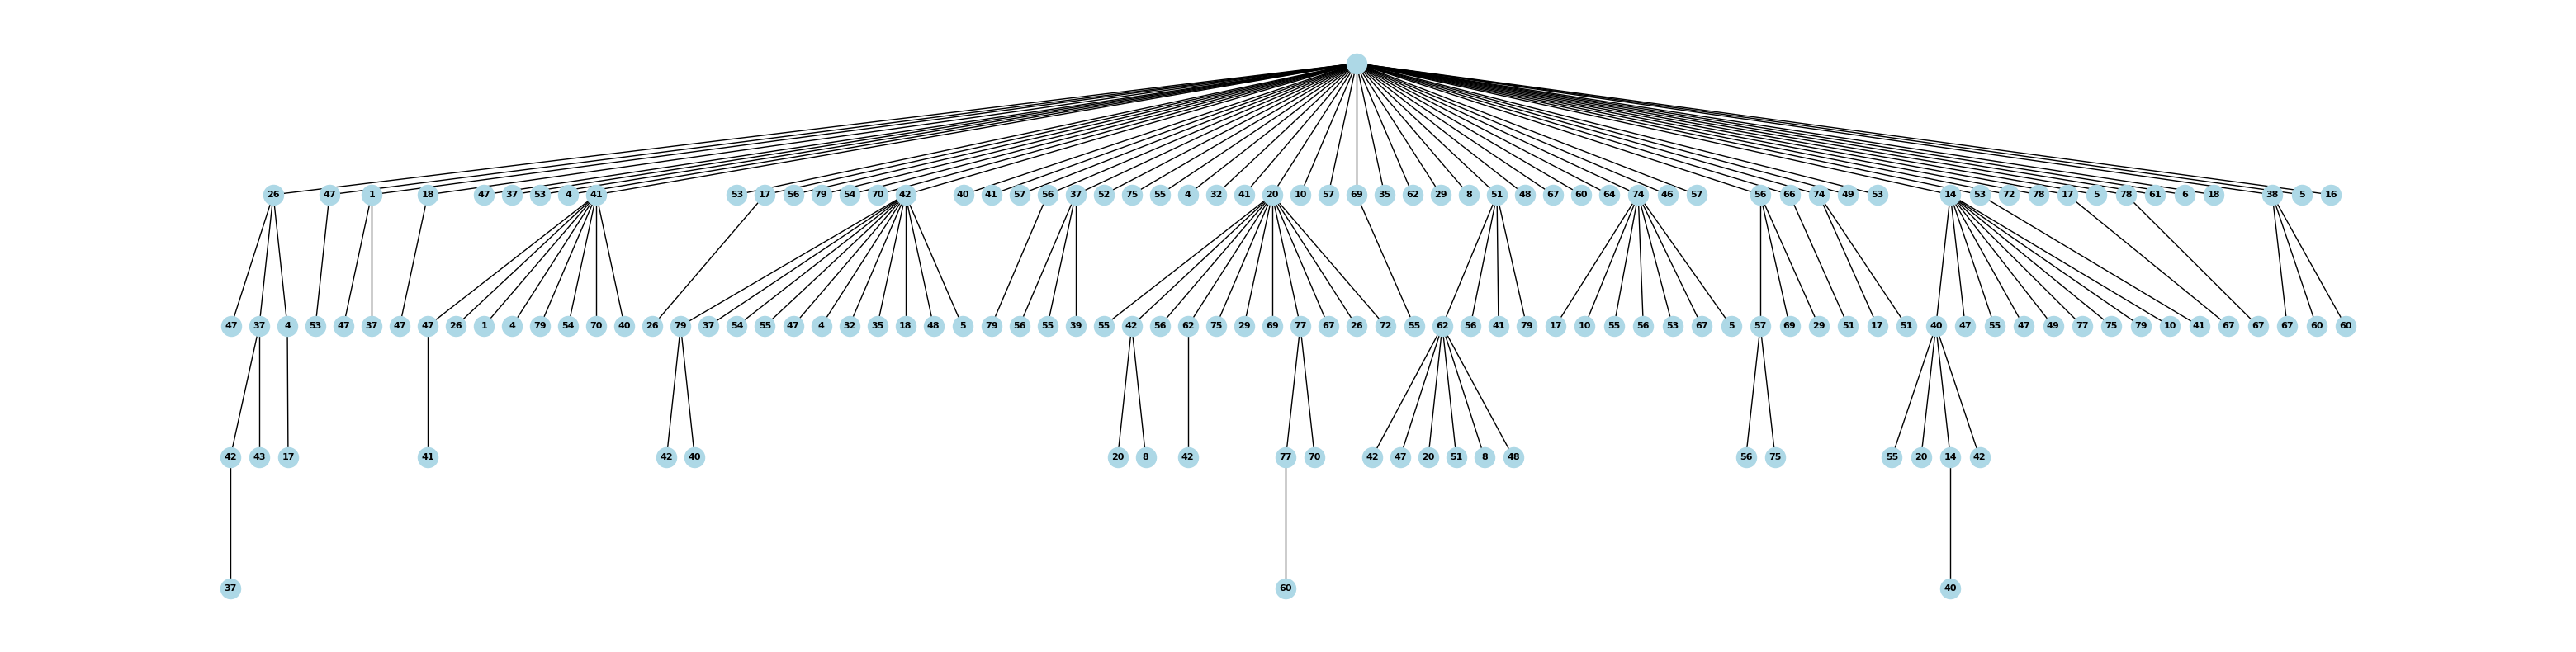

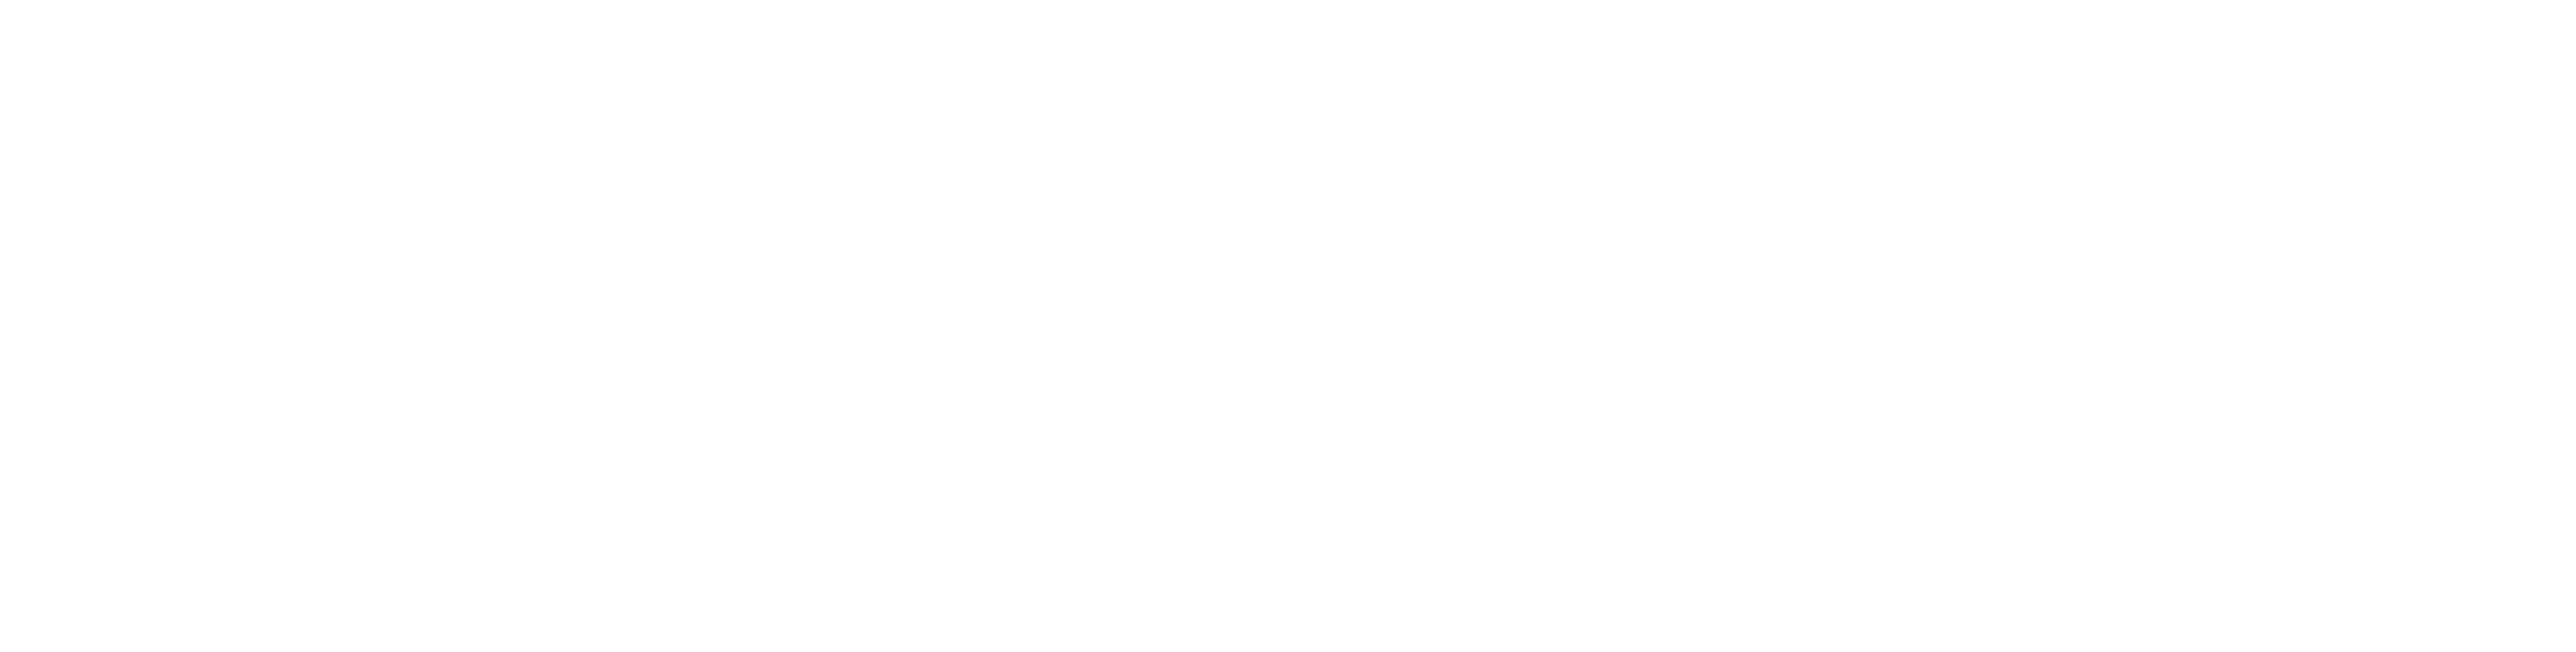

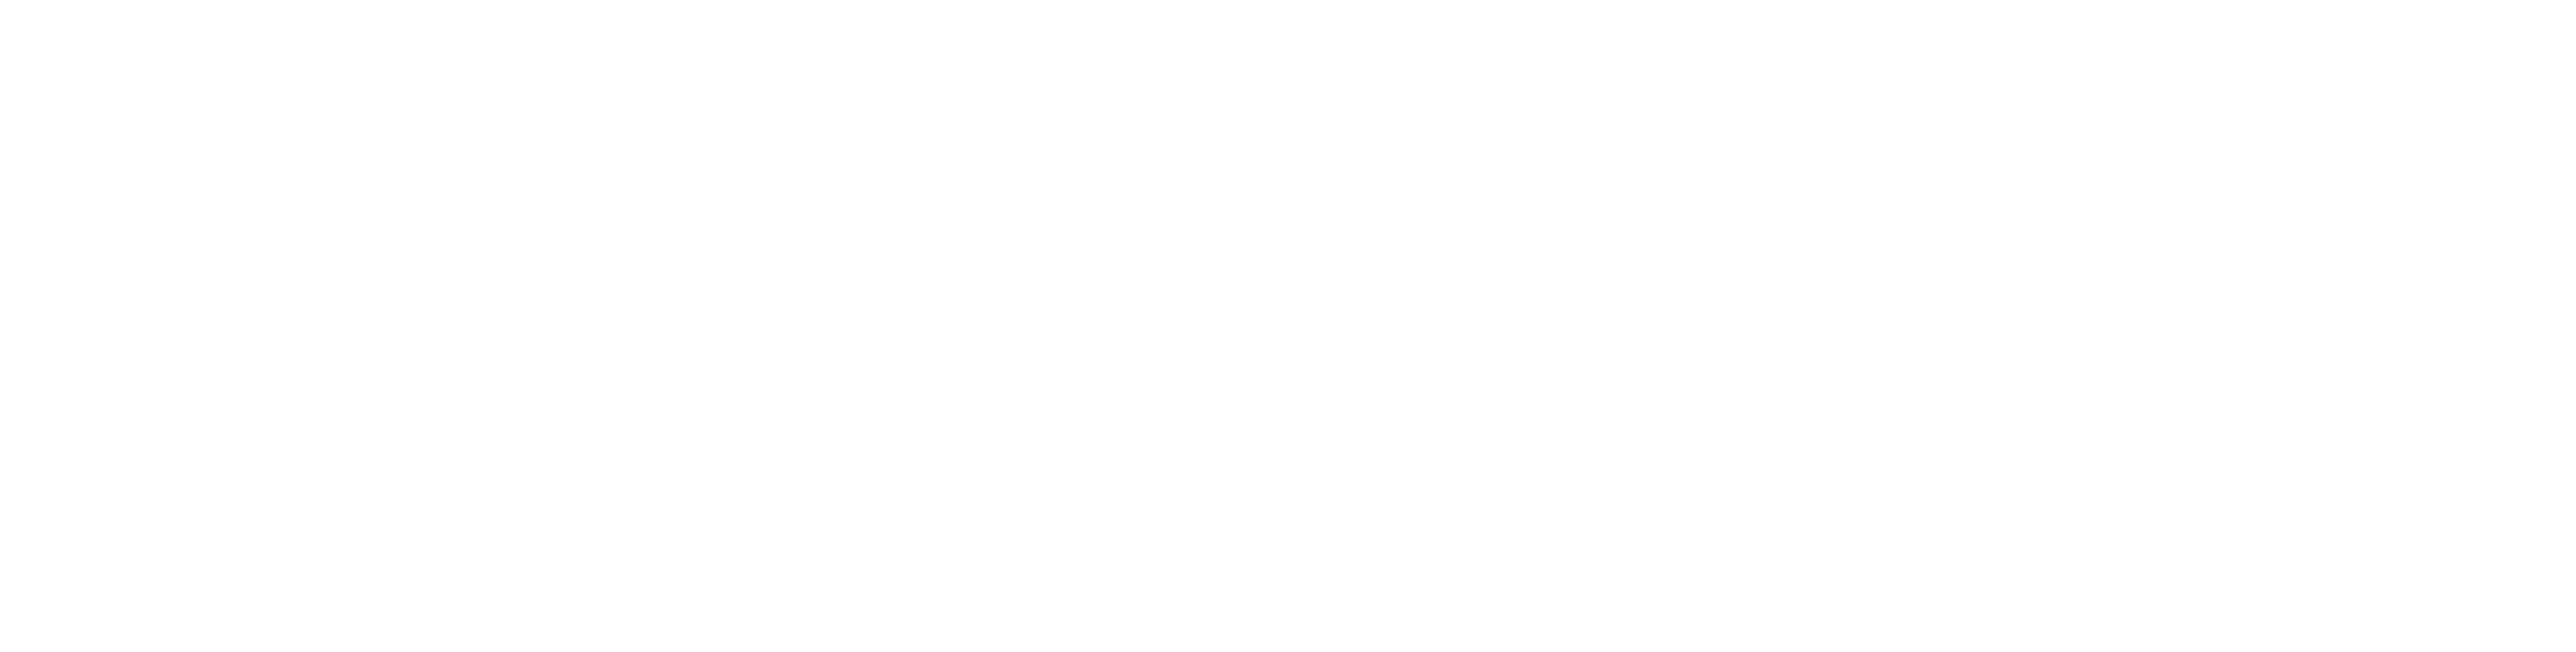

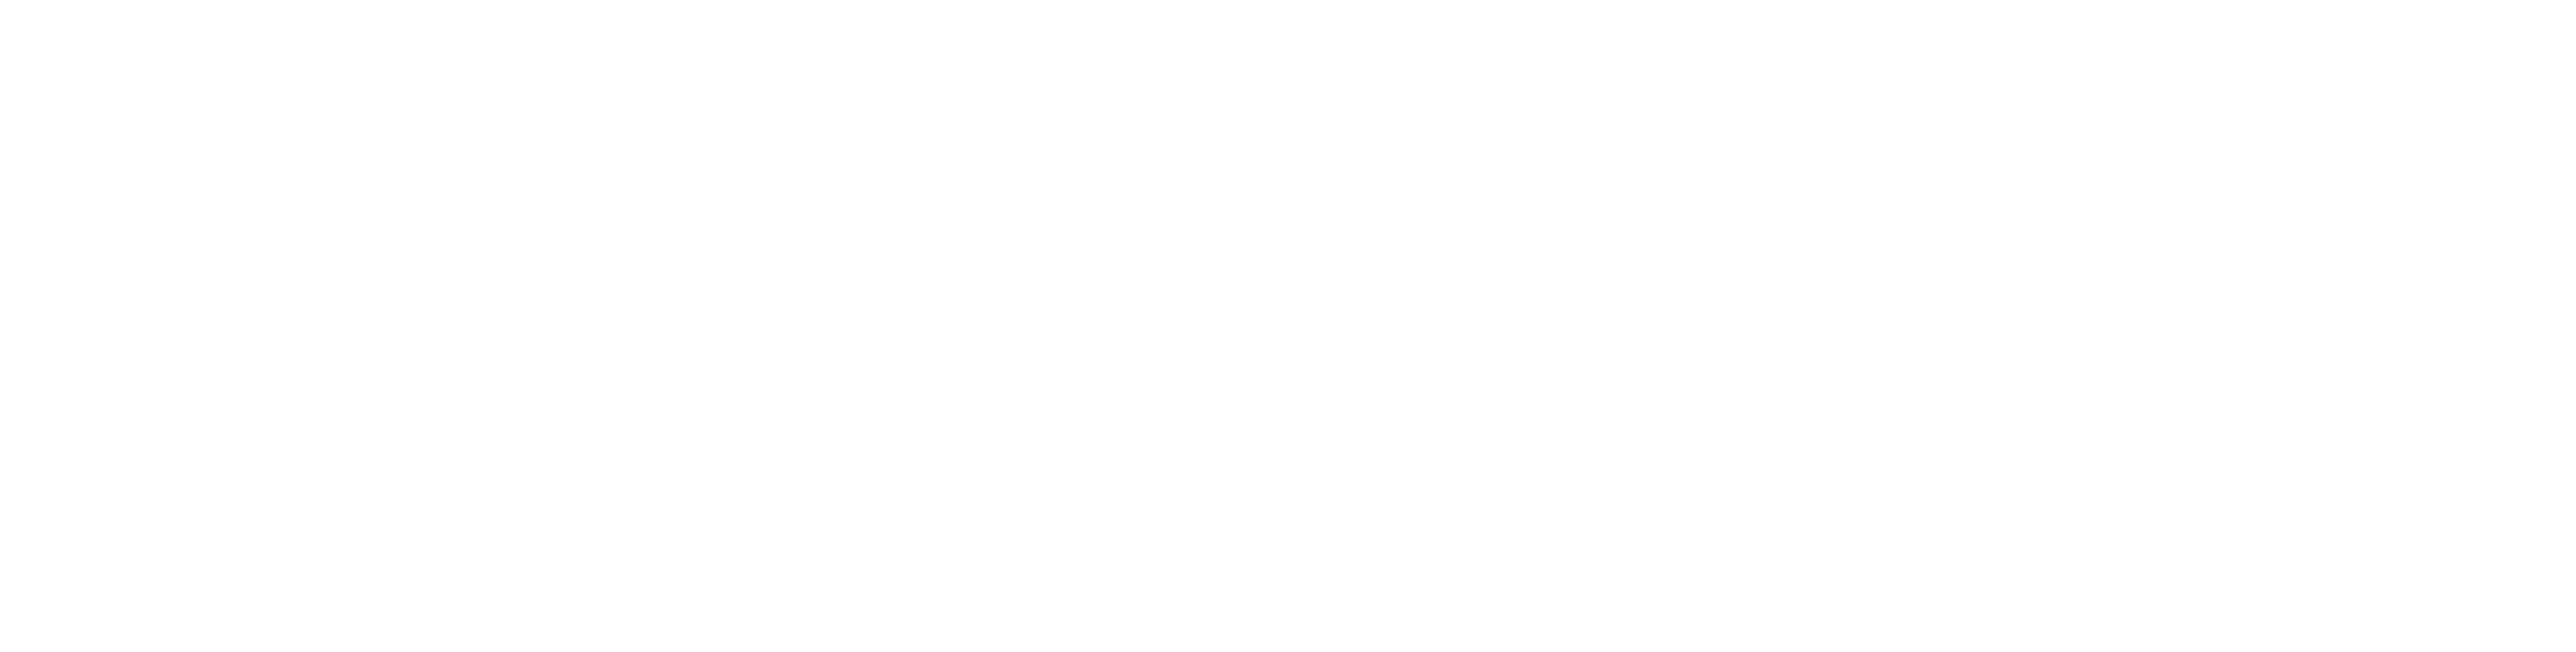

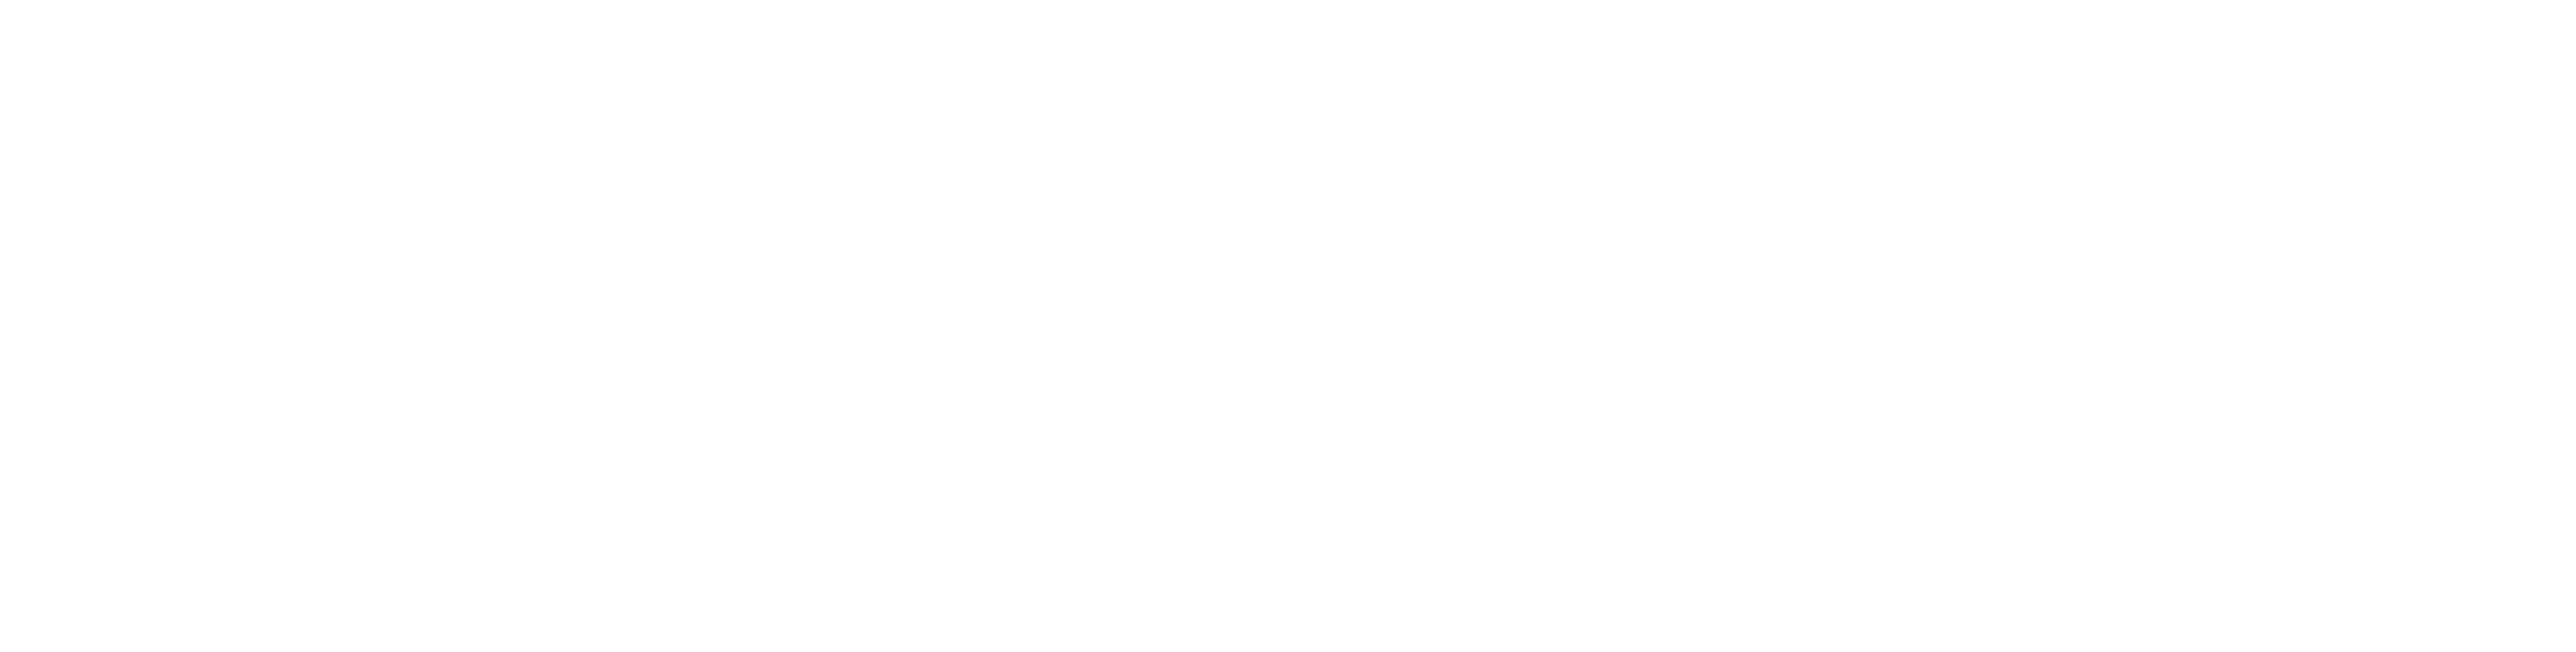

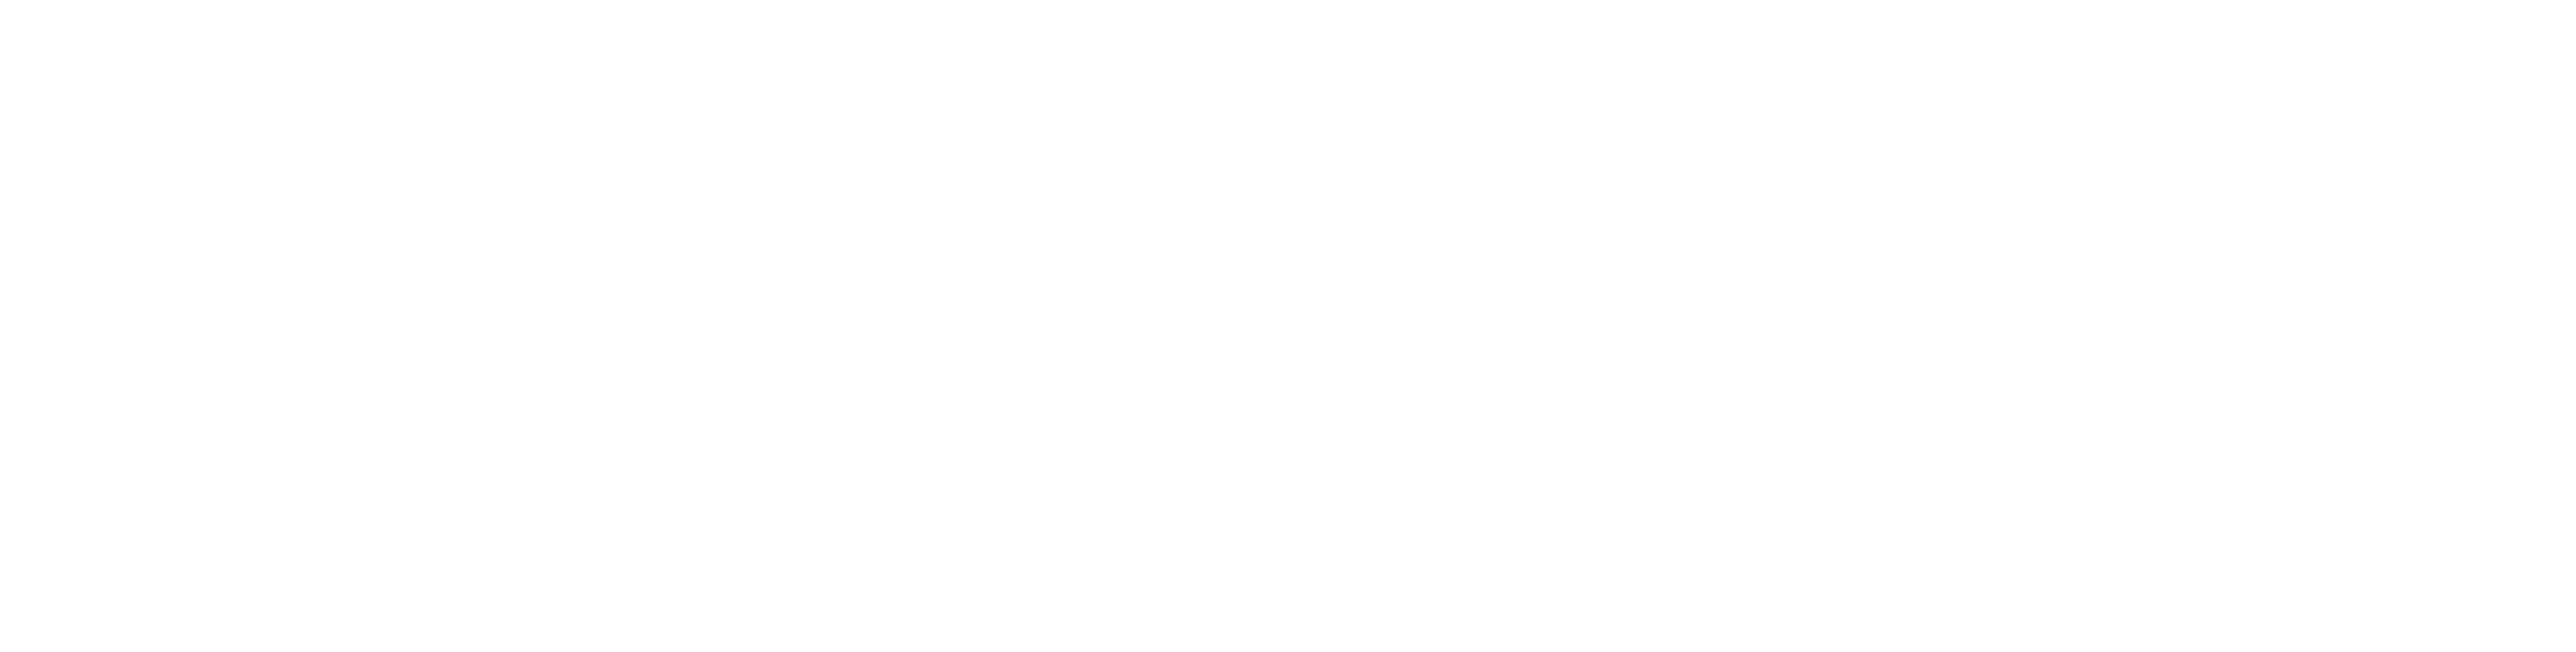

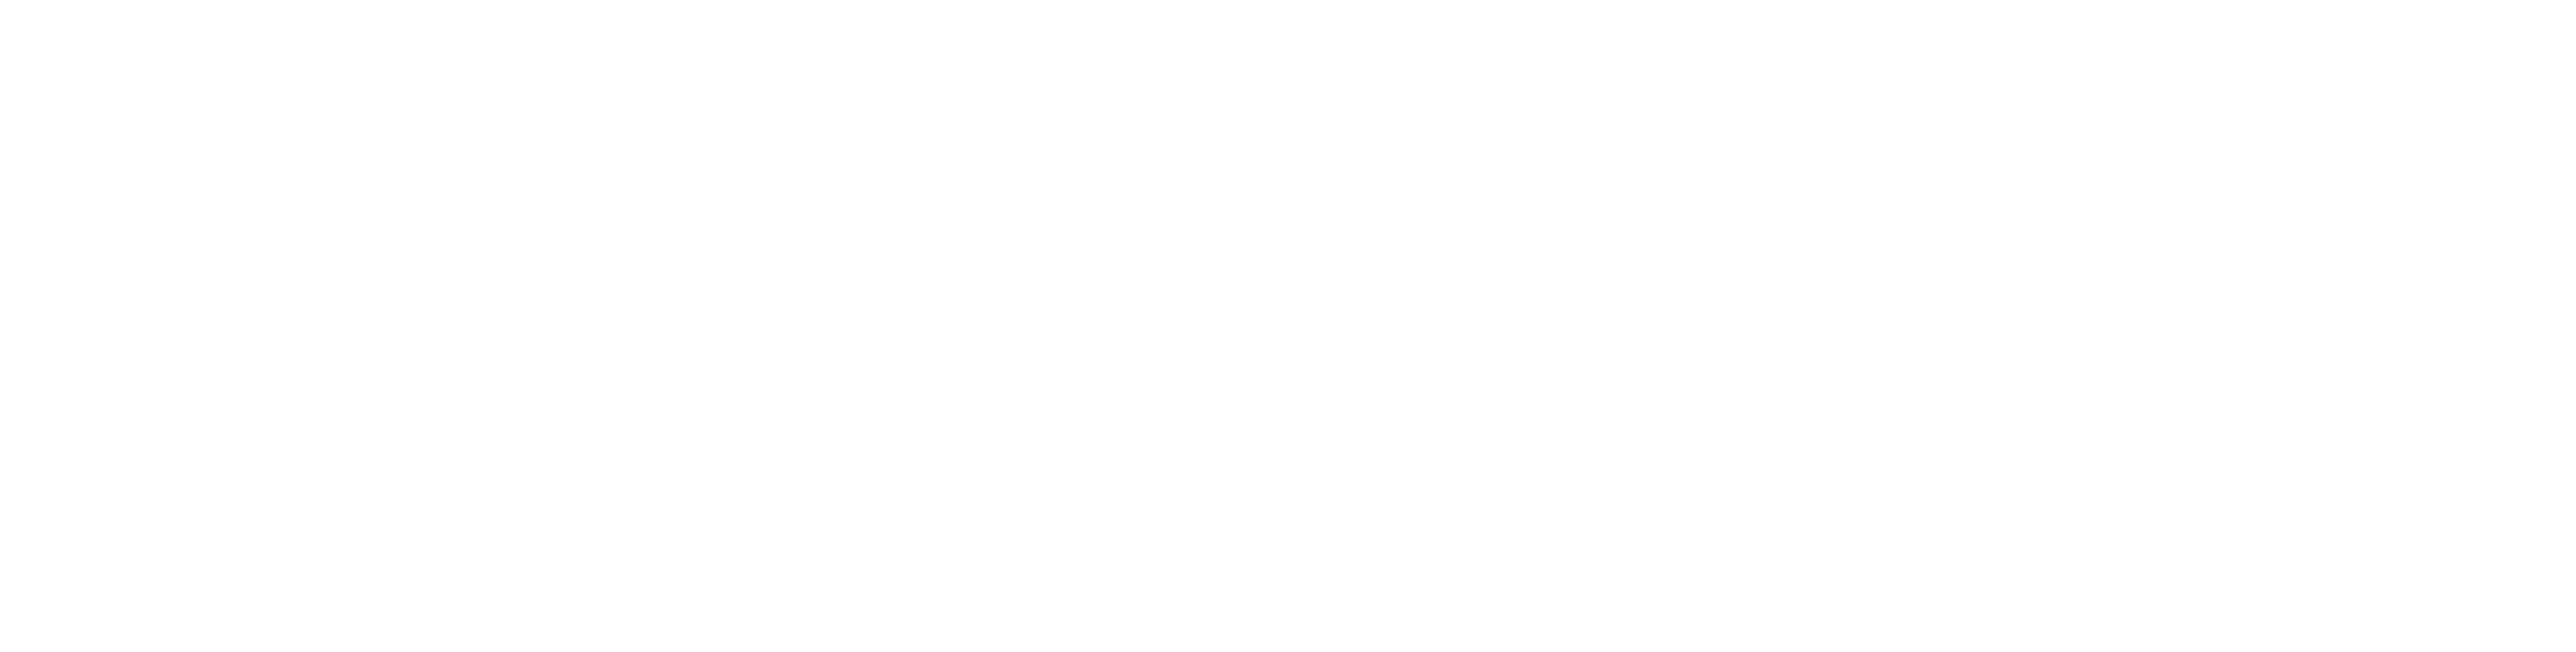

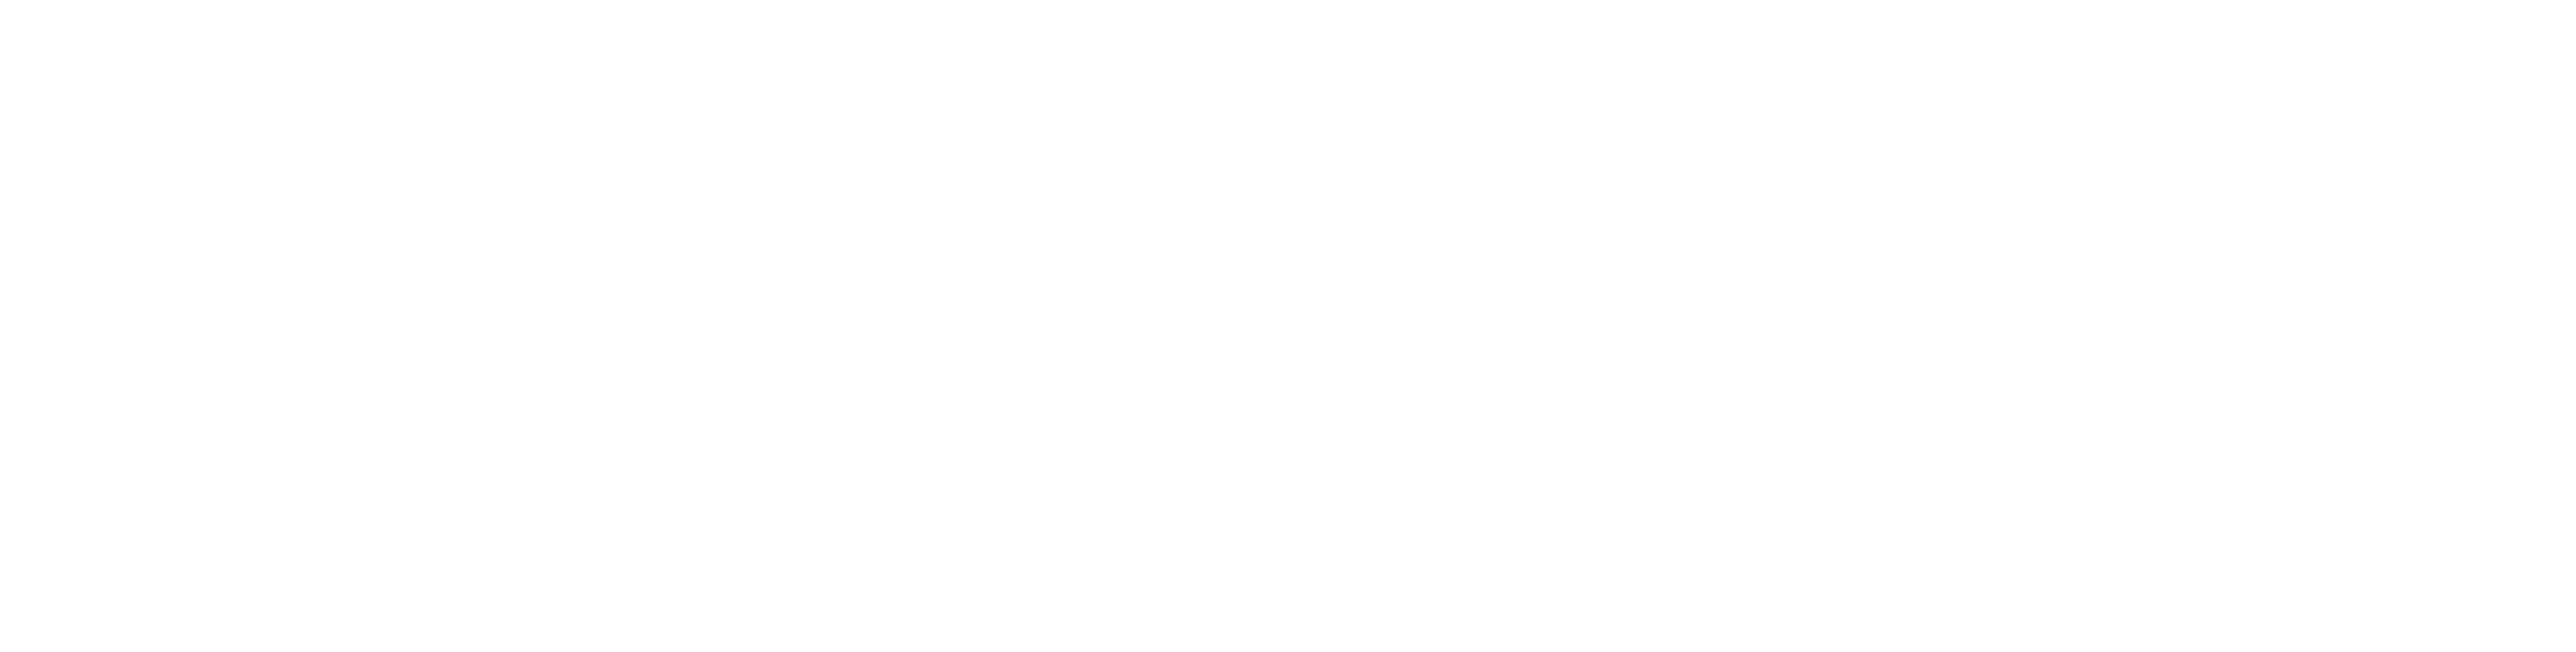

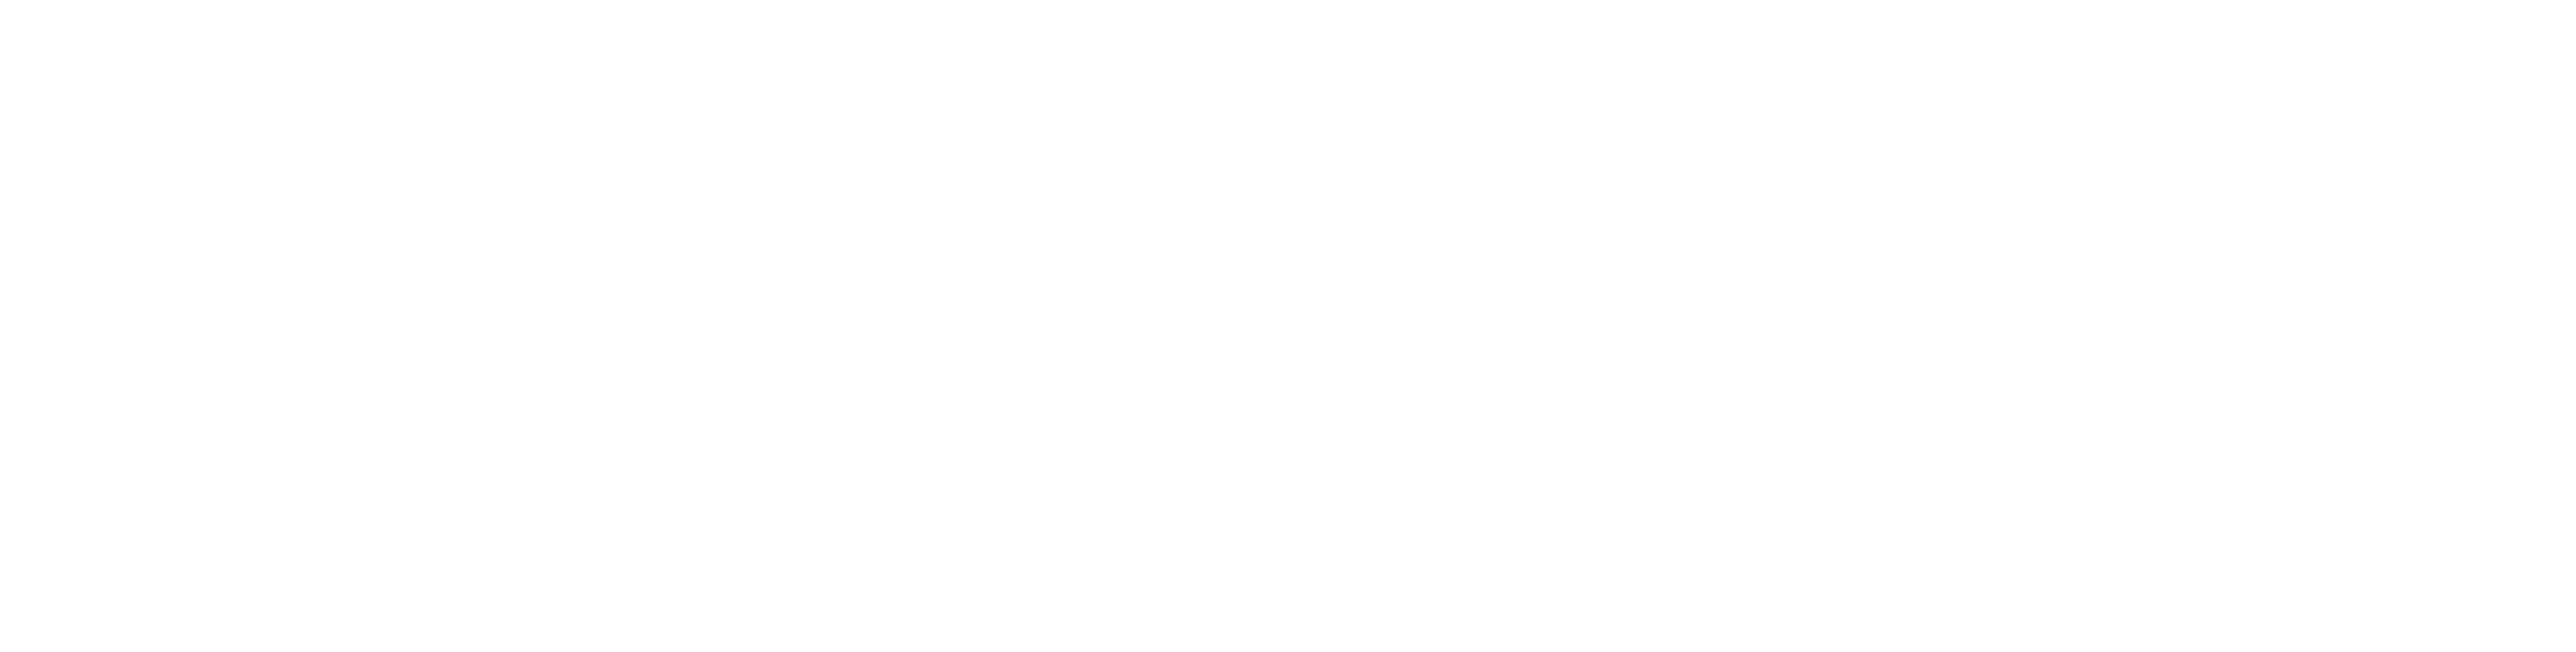

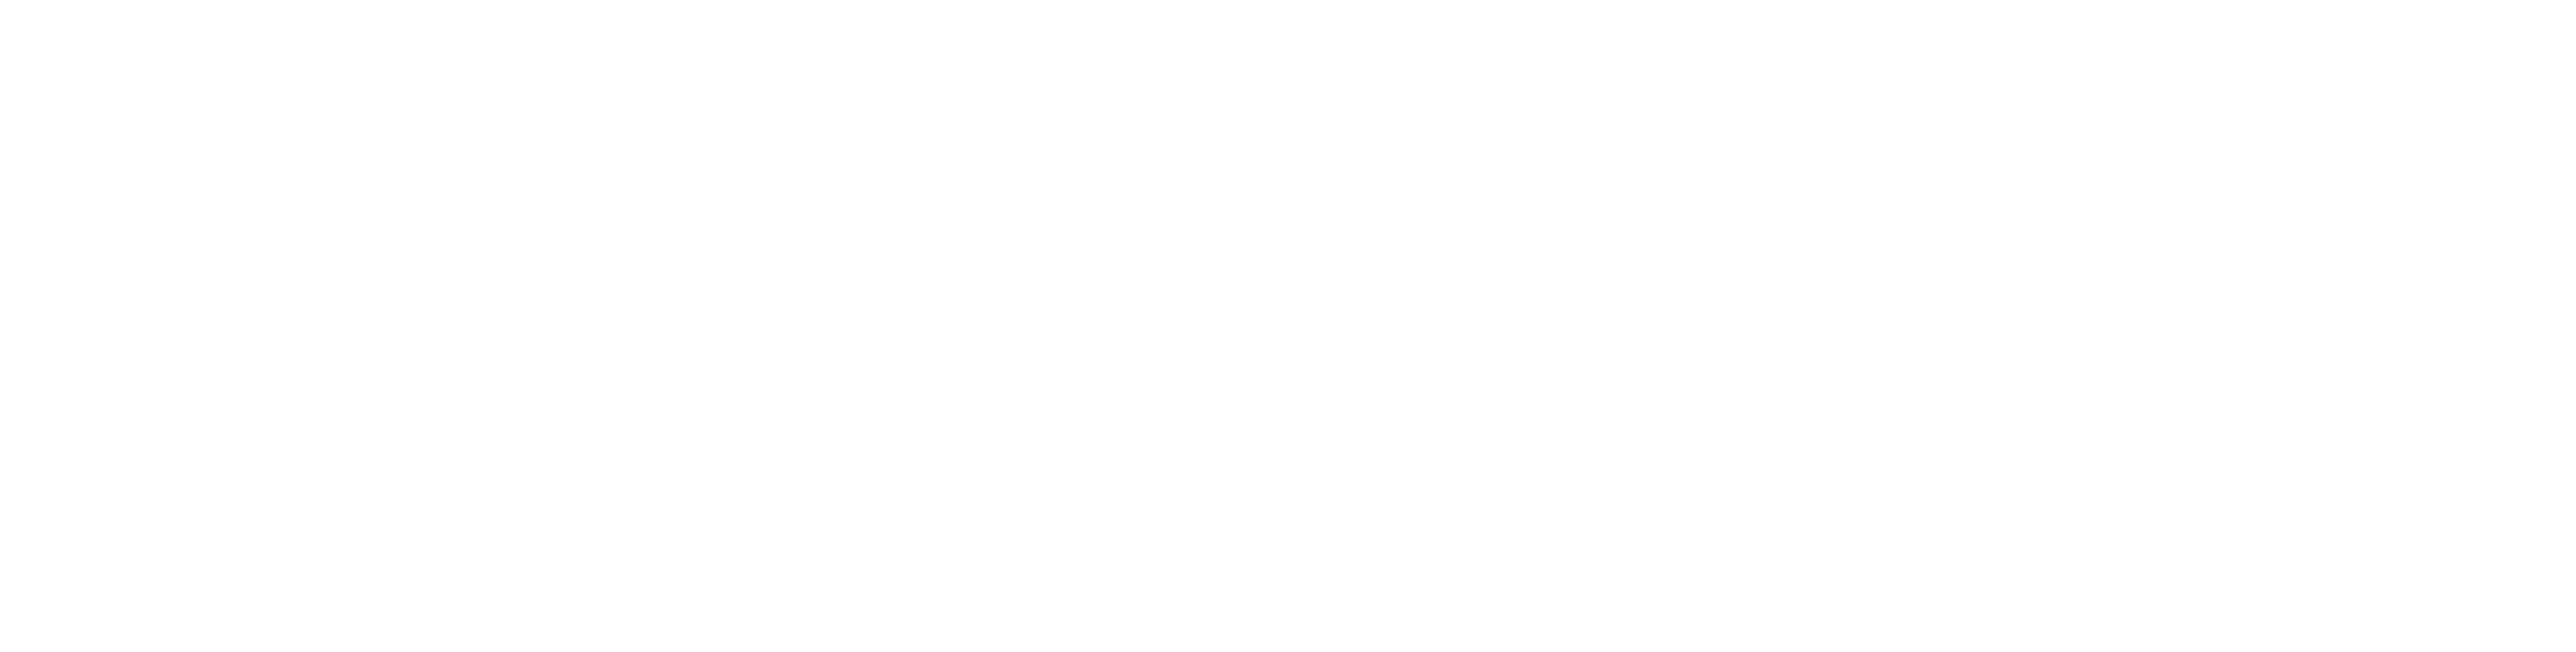

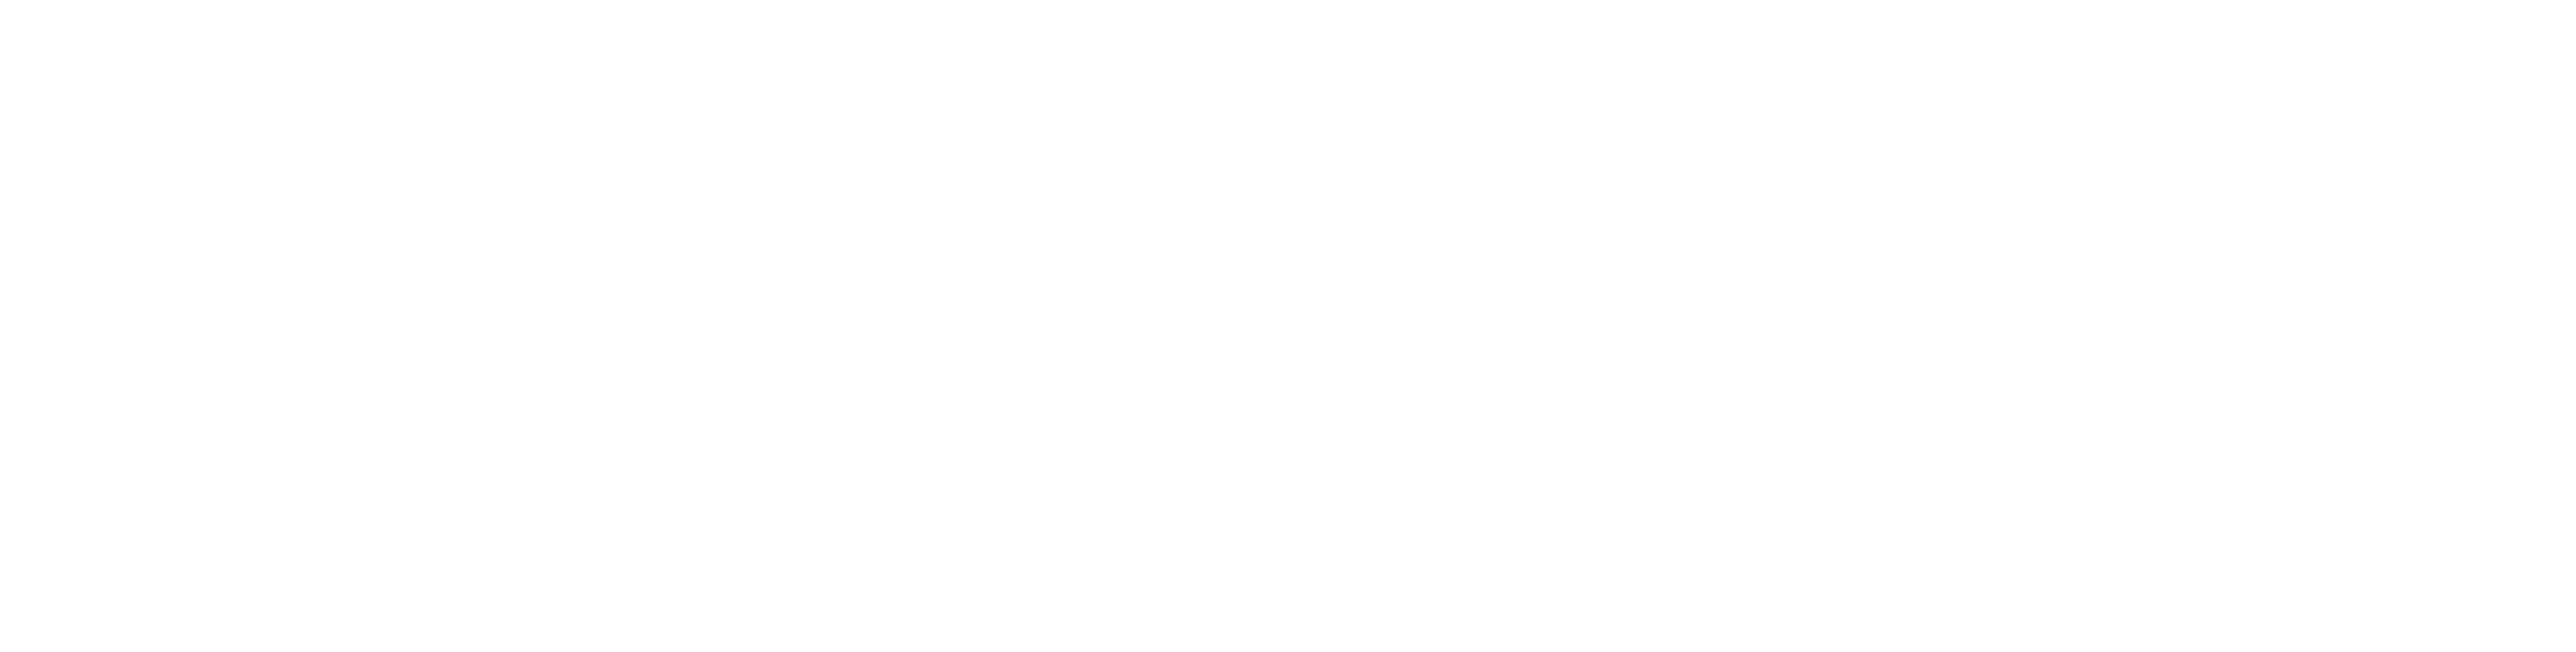

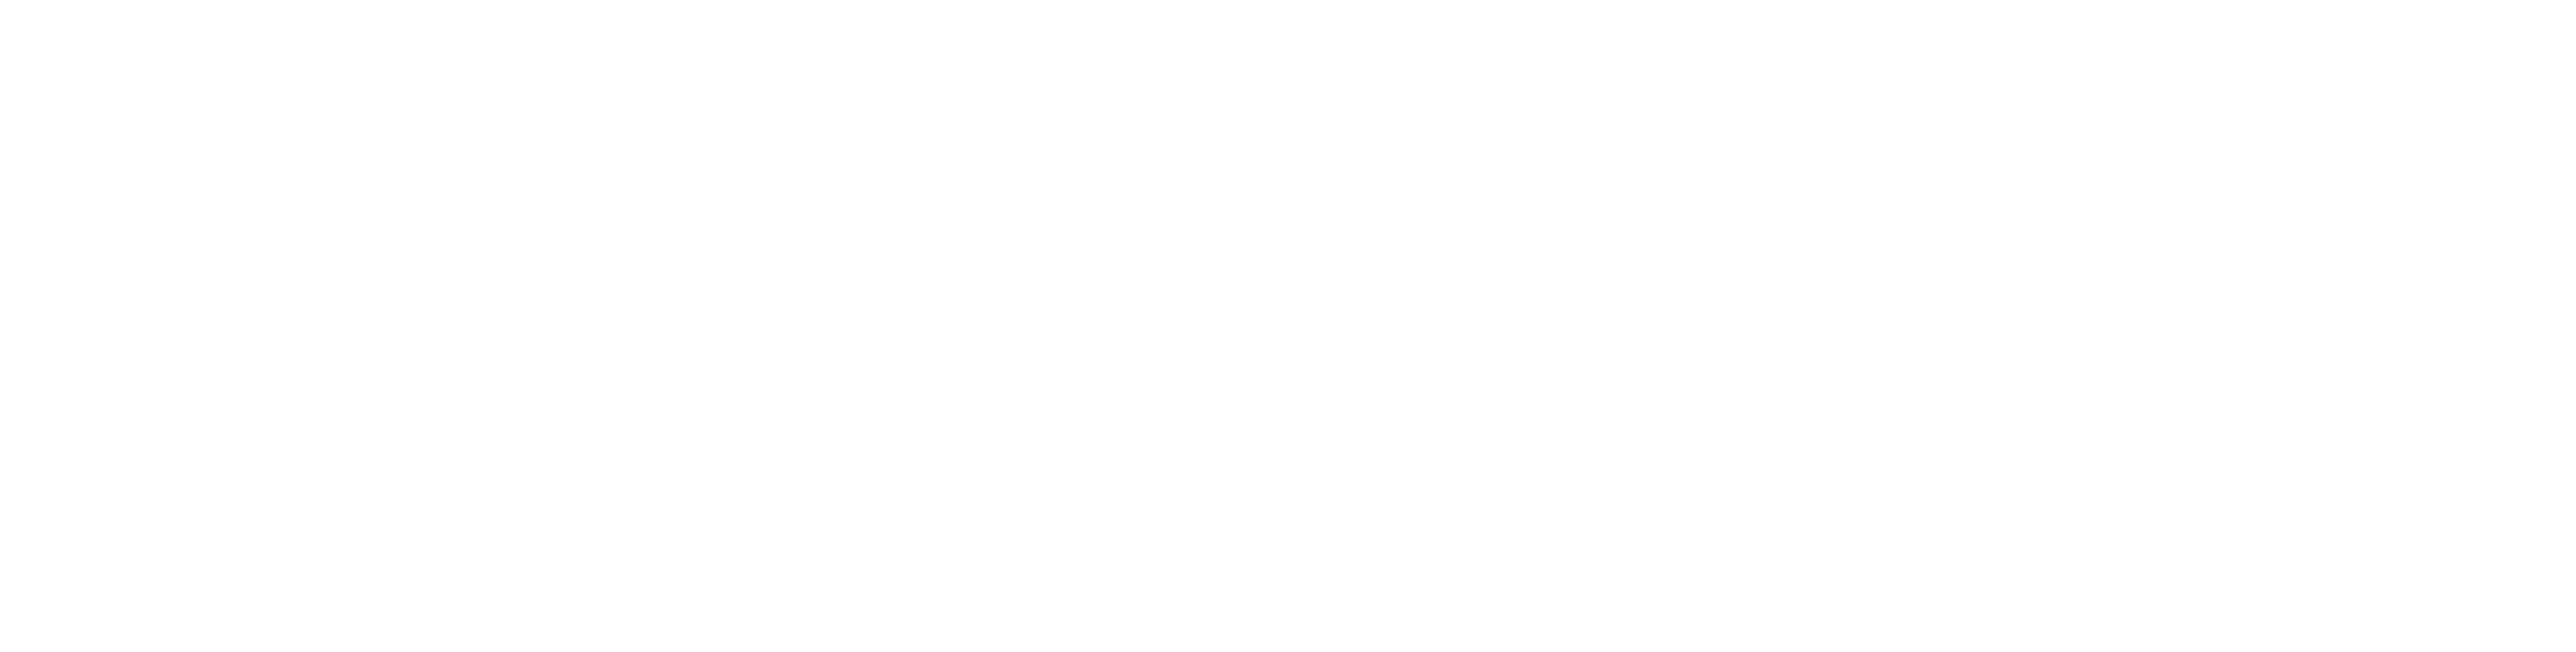

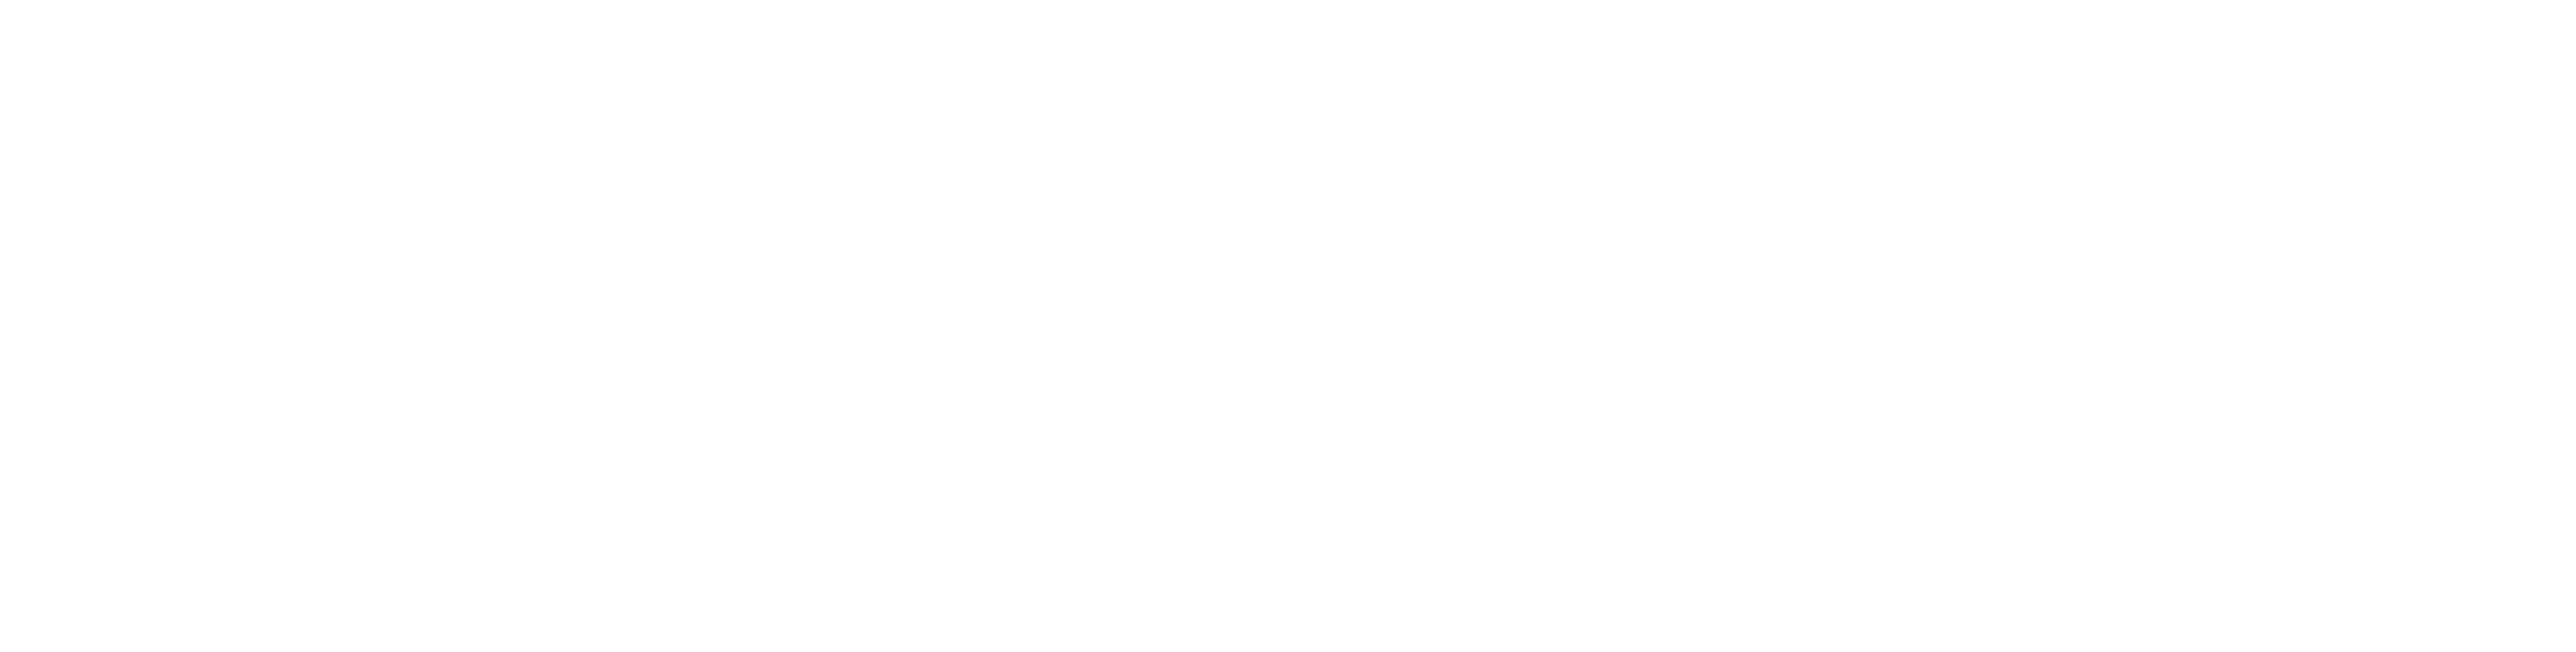

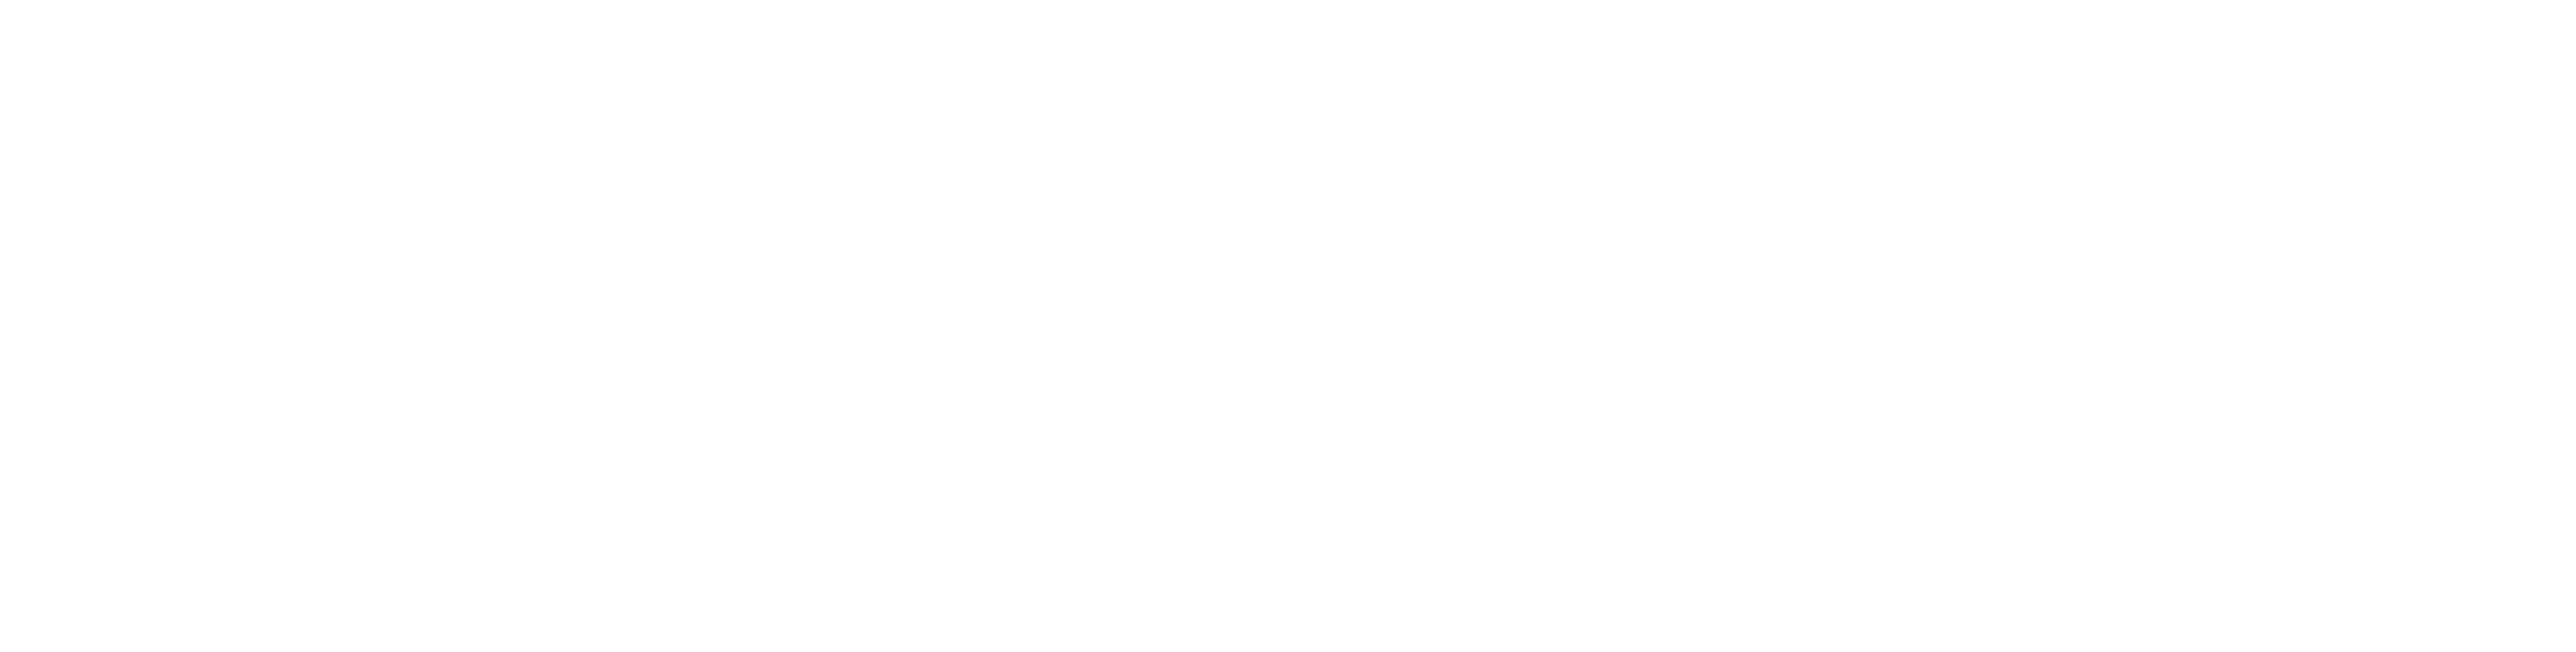

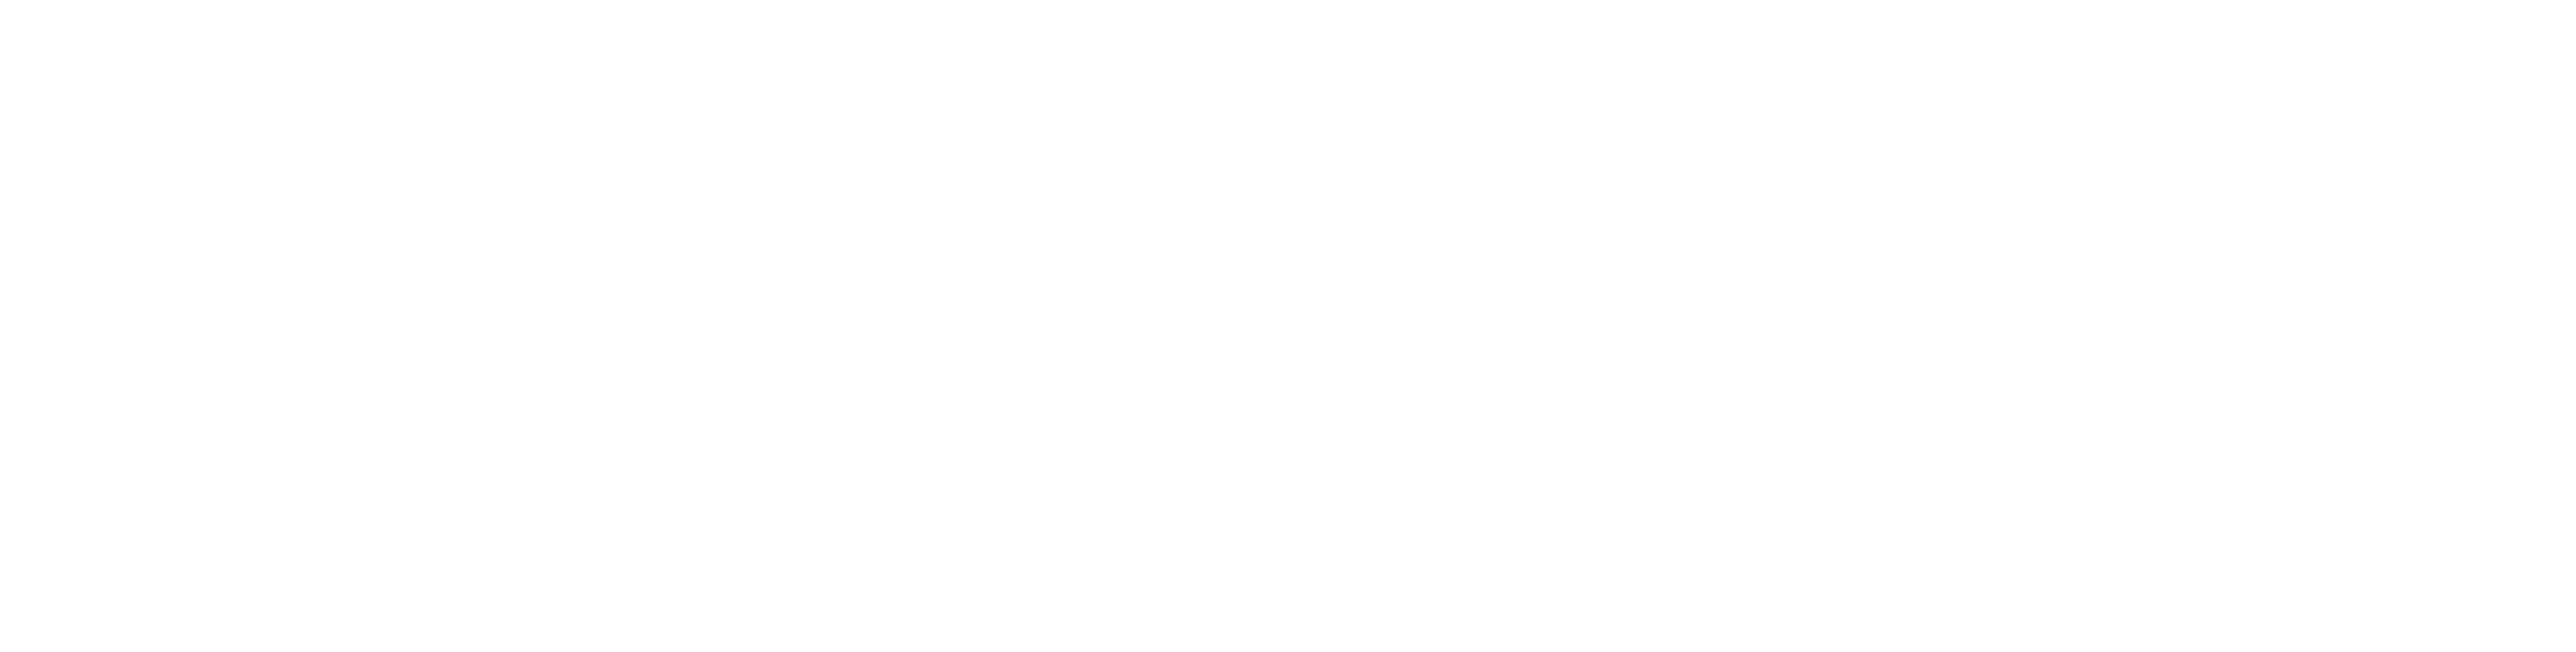

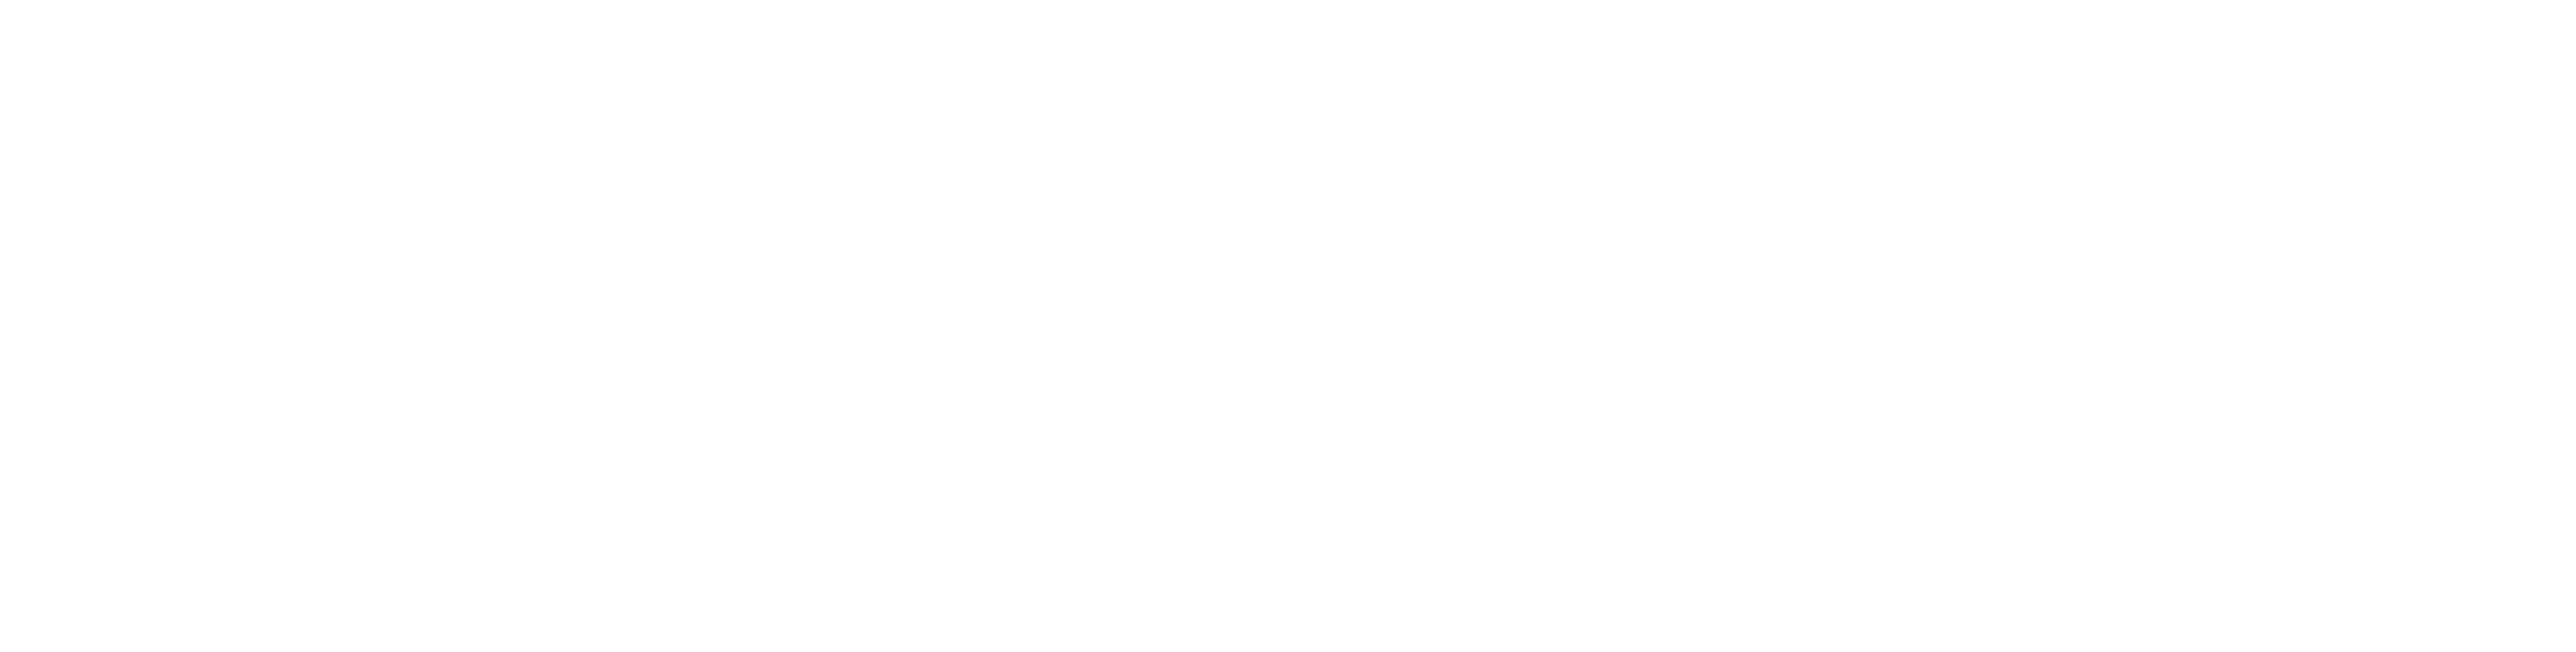

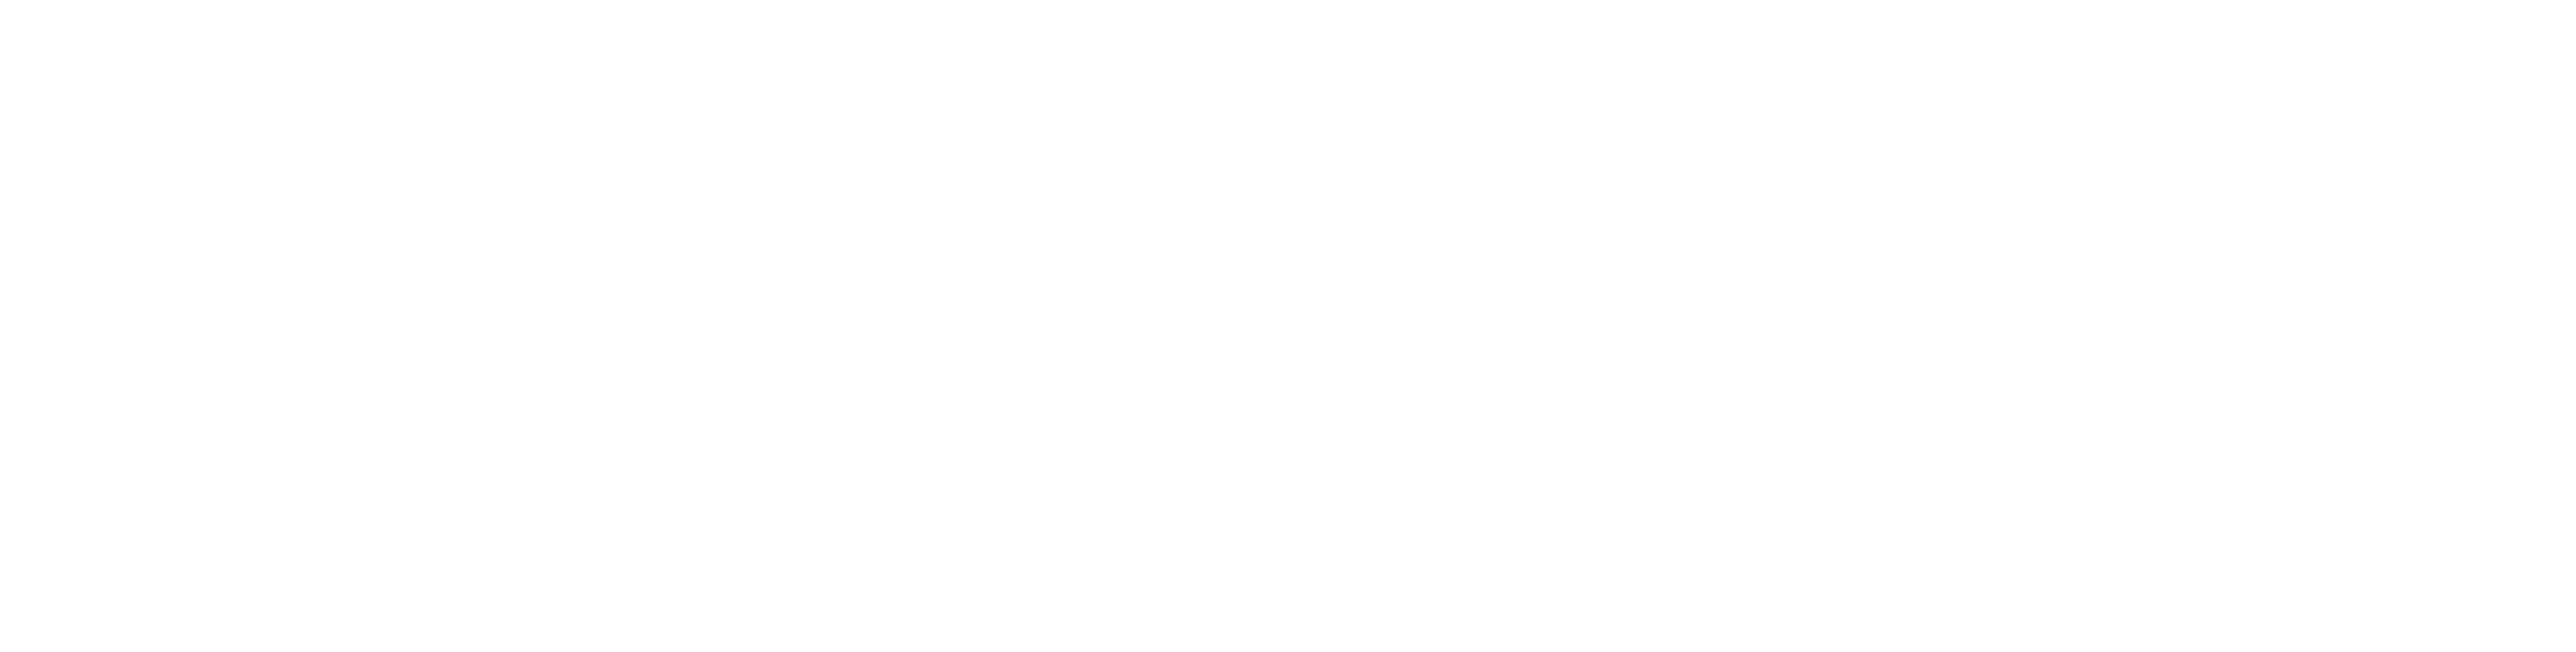

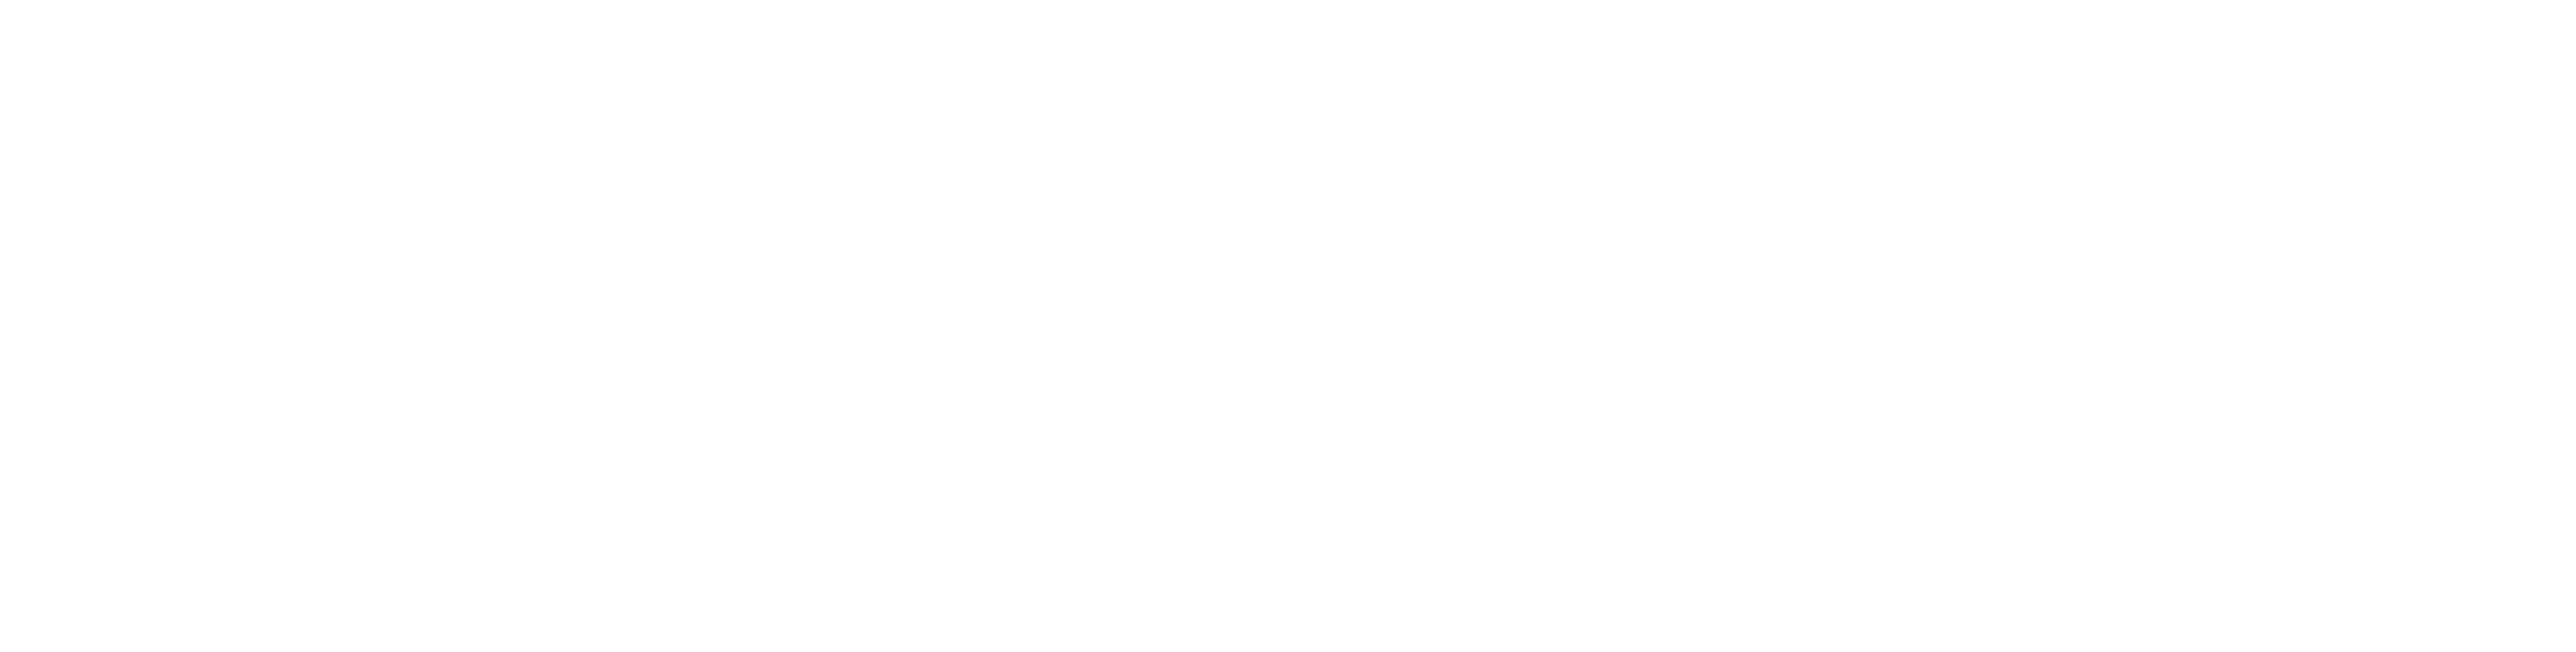

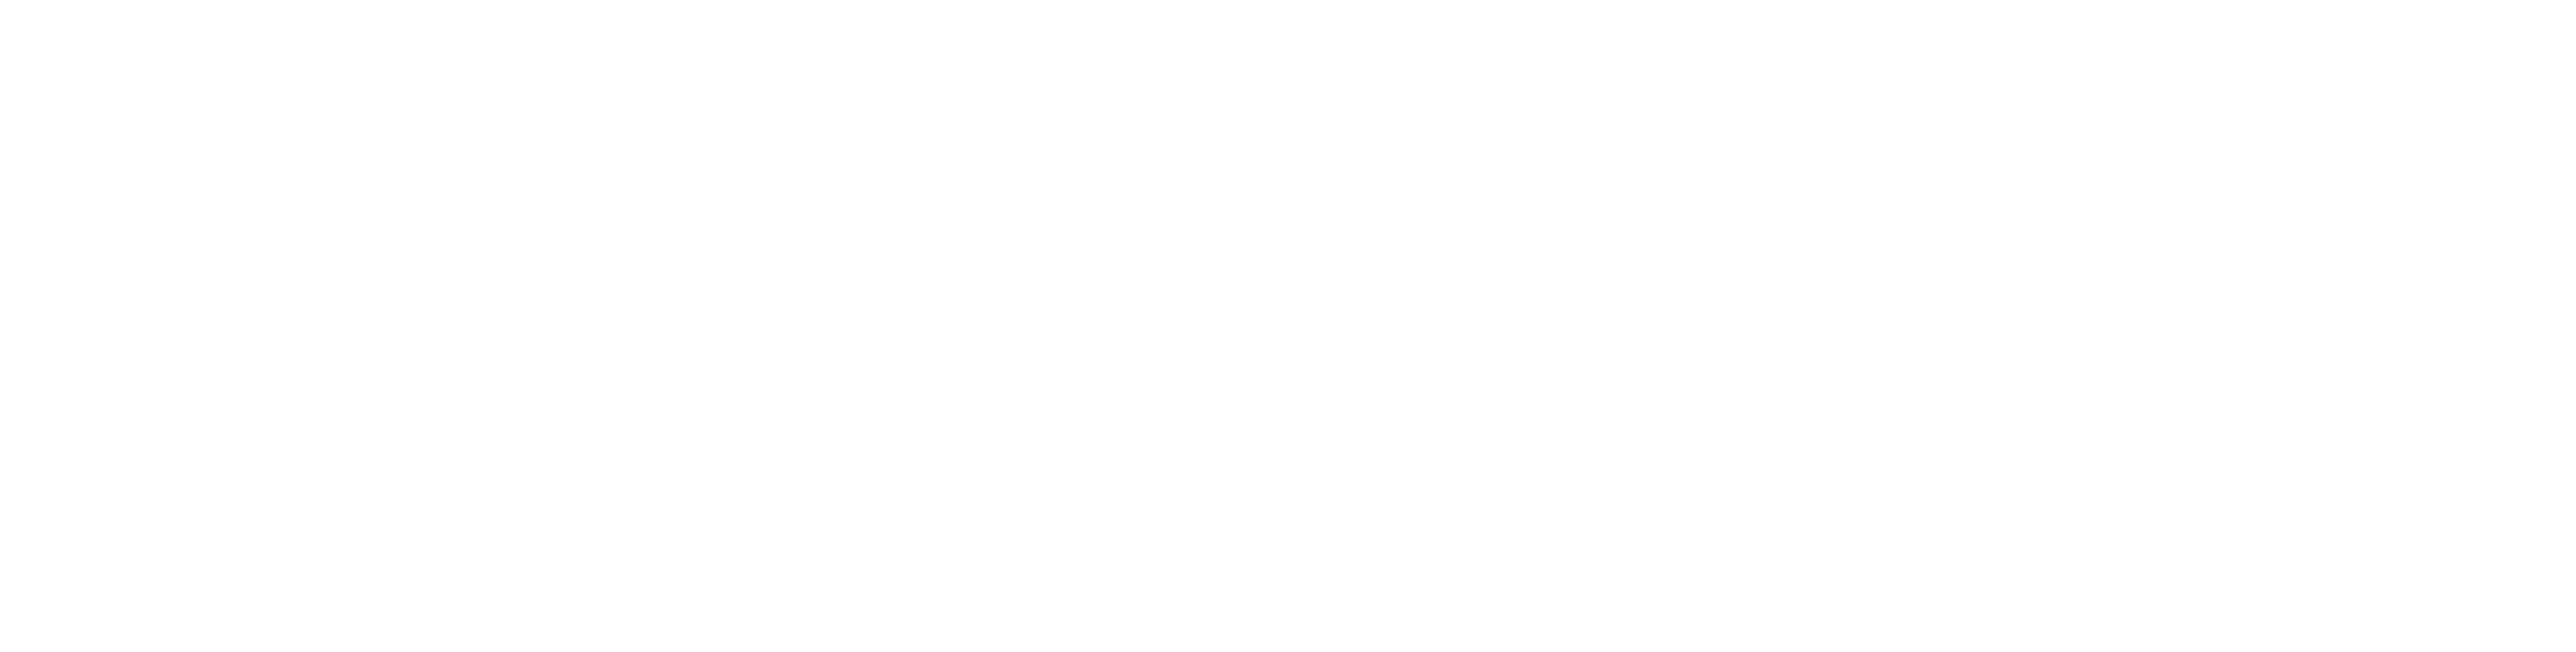

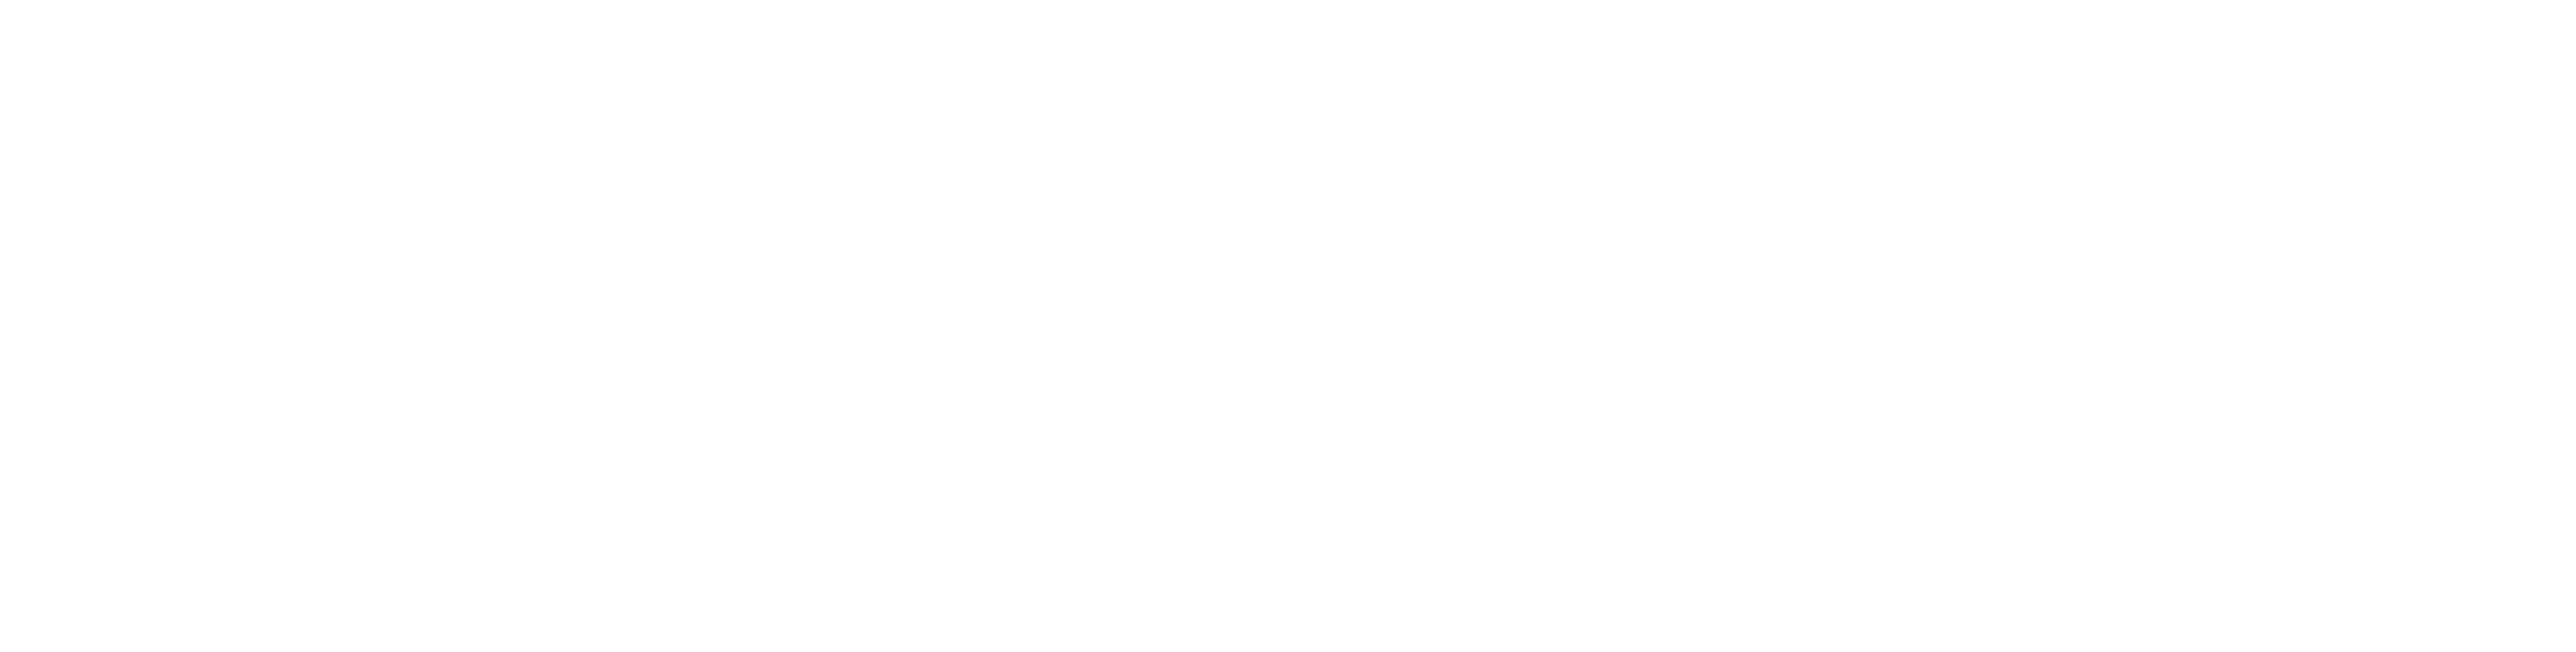

In [19]:
# Visualize the thread structure in tree form
for i in range(1, 21):
    thread_tree = []
    node_labels = {}
    
    temp = list(data.values())[0]
    temp = temp[temp["post_id"] == i]
    
    for j, r in temp.iterrows():
        if r["parent_comment_id"] == -1:
            thread_tree.append((0, r["comment_id"]))
        else:
            thread_tree.append((r["parent_comment_id"], r["comment_id"]))
        node_labels[r["comment_id"]] = r["user_id"]
    
    G = nx.Graph()
    G.add_edges_from(thread_tree)
    pos = graphviz_layout(G, prog="dot")
    
    fig, axs = plt.subplots(1, 1, figsize=(40, 10))
    nx.draw(
        G, pos, with_labels=True, labels=node_labels, node_size=300,
        node_color='lightblue', font_weight='bold', font_size=8
    )
    if save_figs:
        plt.savefig("figures/sim_thread-tree.jpg")
    plt.show()

In [20]:
# temp = discussions_data.groupby(["ParticipantID", "post_title"]).size().groupby("ParticipantID").idxmax().apply(pd.Series)[1]

# for i, r in temp.items():
#     comments = discussions_data[
#     discussions_data["ParticipantID"] == i
#     ]
#     comments = comments[comments["post_title"] == r][
#     "created_comment"
#     ]
    
#     fig, ax = plt.subplots(figsize=(12, 2))
    
#     # Plot vertical lines at each comment time
#     for comment in pd.to_datetime(comments):
#         ax.axvline(x=comment, color='b', linestyle='--', alpha=0.7)
    
#     # Set the title and labels
#     ax.set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
#                  pd.to_datetime(comments).max() + pd.Timedelta(minutes=1)])
#     ax.set_ylim([0, 0.1])
#     ax.set_title(f"Comment Times for Participant {i}\n{r}")
#     ax.set_xlabel("Time")
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45)    
#     plt.yticks([])
    
#     # Show the plot
#     plt.tight_layout()
#     plt.show()

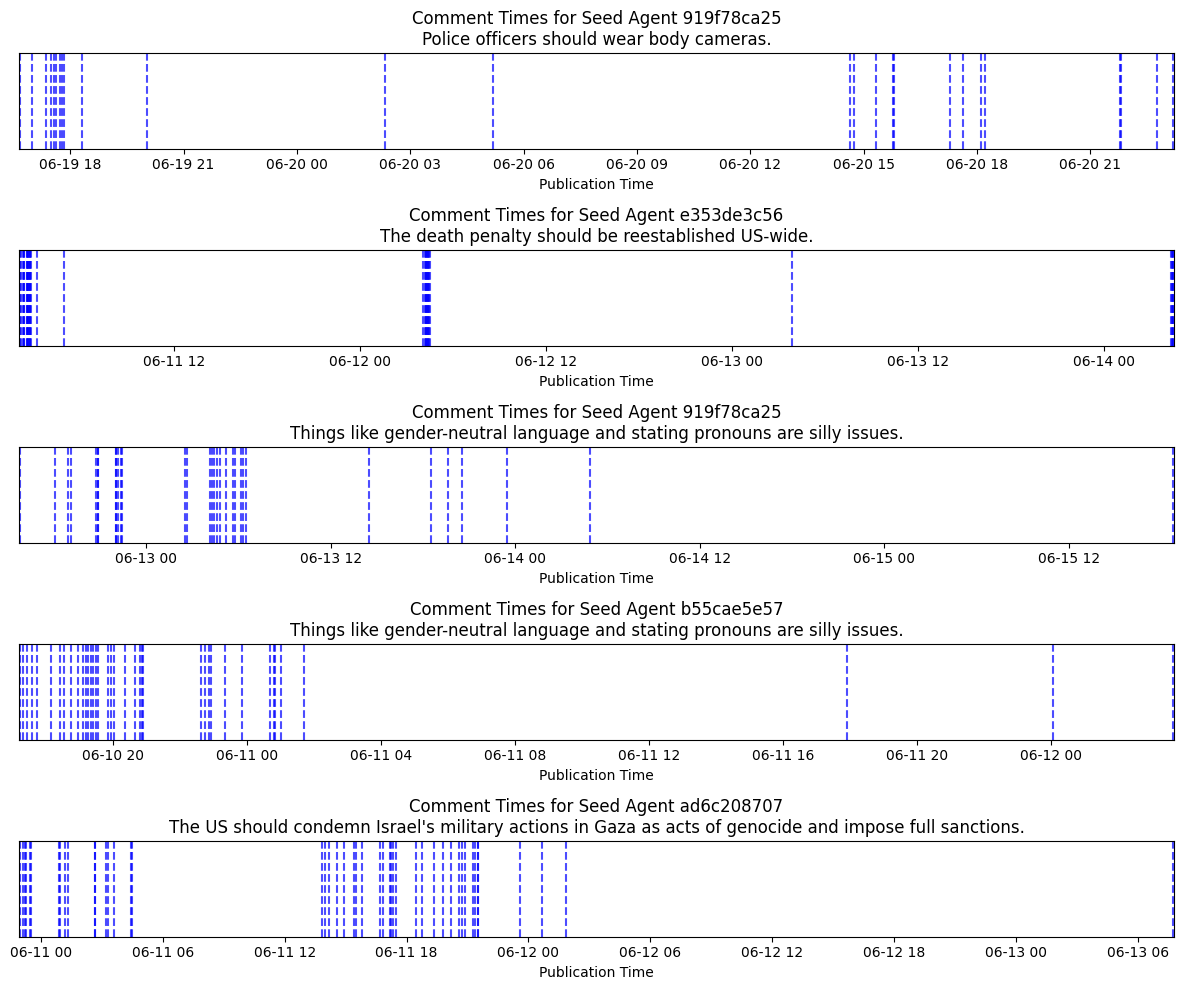

In [21]:
# Seed
temp = discussions_data.groupby(["ParticipantID", "post_title"]).size().sort_values().tail(5)

j = 0
fig, axs = plt.subplots(5, 1, figsize=(12, 10))
for i, r in temp.items():
    comments = discussions_data[
    discussions_data["ParticipantID"] == i[0]
    ]
    comments = comments[comments["post_title"] == i[1]][
    "created_comment"
    ]
    
    for comment in pd.to_datetime(comments):
        axs[j].axvline(x=comment, color='b', linestyle='--', alpha=0.7)
    
    axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
                 pd.to_datetime(comments).max() + pd.Timedelta(minutes=1)])
    axs[j].set_ylim([0, 0.1])
    axs[j].set_title(f"Comment Times for Seed Agent {i[0]}\n{i[1]}")
    axs[j].set_xlabel("Publication Time")

    axs[j].set_yticks([])

    j += 1

plt.tight_layout()
if save_figs:
    plt.savefig("figures/seed_top-5_burst.jpg")
plt.show()

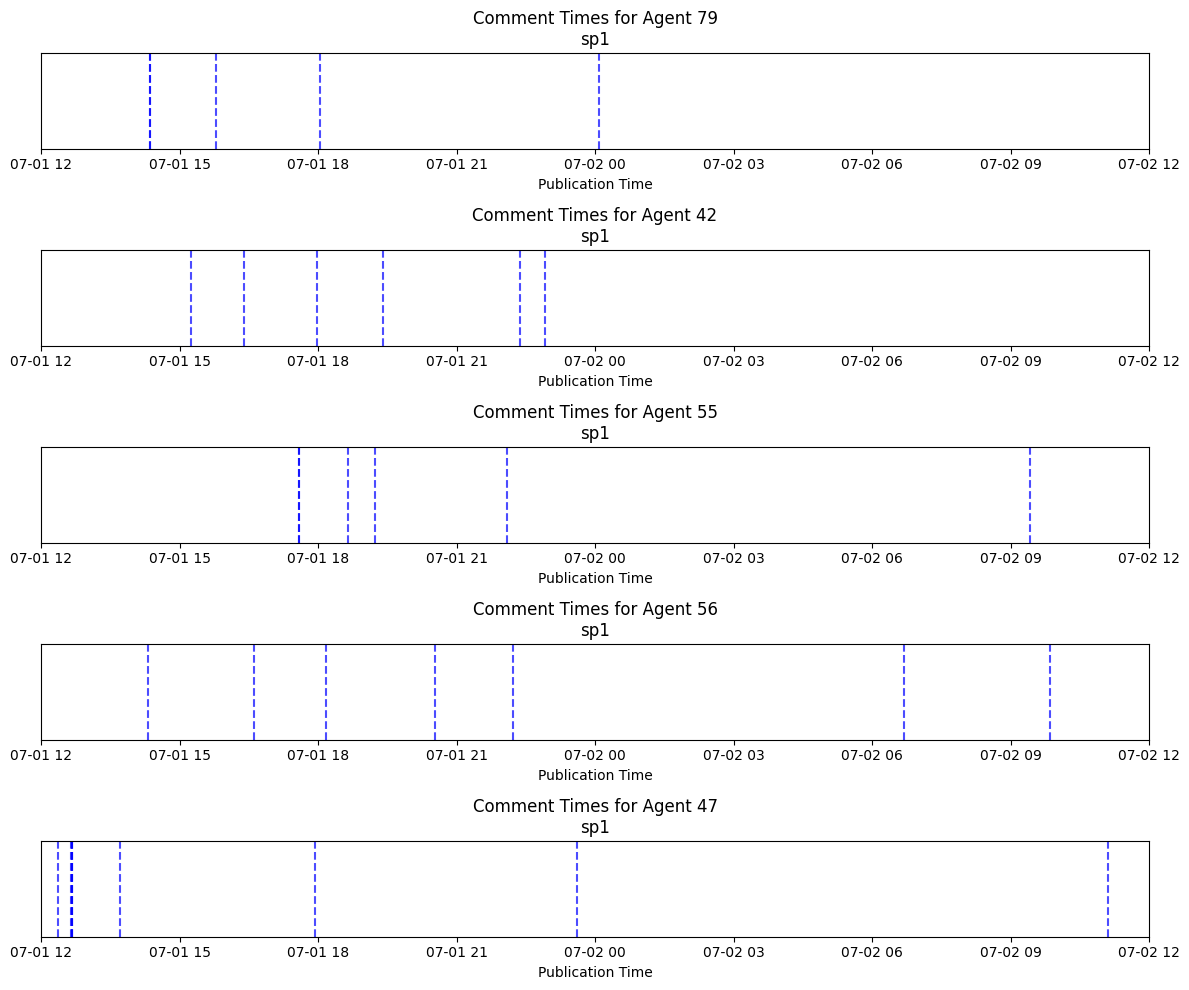

In [26]:
# SIM
temp = t_df.groupby(["user_id", "seed_post"]).size().sort_values().tail(5)

j = 0
fig, axs = plt.subplots(5, 1, figsize=(12, 10))
for i, r in temp.items():
    comments = t_df[
    t_df["user_id"] == i[0]
    ]
    comments = comments[comments["seed_post"] == i[1]][
    "created_at"
    ]
    
    for comment in pd.to_datetime(comments):
        axs[j].axvline(x=comment, color='b', linestyle='--', alpha=0.7)
    
    # axs[j].set_xlim([pd.to_datetime(comments).min() - pd.Timedelta(minutes=1),
    #              pd.to_datetime(comments).max() + pd.Timedelta(minutes=1)])
    axs[j].set_xlim([datetime(2025, 7, 1, 12, 00, 00),
                     datetime(2025, 7, 2, 12, 00, 00)])
    axs[j].set_ylim([0, 0.1])
    axs[j].set_title(f"Comment Times for Agent {i[0]}\n{i[1]}")
    axs[j].set_xlabel("Publication Time")

    axs[j].set_yticks([])

    j += 1

plt.tight_layout()
if save_figs:
    plt.savefig("figures/sim_top-5_burst.jpg")
plt.show()

In [70]:
# Visualize custom activation function (visualize with sim data!)
# temp = []
# for i in range(1000):
#     temp.append(len(su.activation_function(seed_data.set_index("ParticipantID"),
#                                            "/../abyss/home/oasis/oasis-rutschmanna/data/dbs/reddit-sim_dp1_qwen-18h_12-27.db",
#                                            print_info=False)))

# plt.hist(temp)
# plt.show()

In [71]:
# Visualize Seed activation probability function
discussions_data["created_comment"] = pd.to_datetime(discussions_data["created_comment"])
discussions_data["interevent_diff"] = discussions_data.sort_values(
    ["ParticipantID", "created_comment"]
).groupby("ParticipantID")["created_comment"].diff().dt.total_seconds()

In [72]:
# Get most active seed user
discussions_data.groupby("ParticipantID").size().sort_values()

ParticipantID
fb2ea6bfbb      1
223213b557      1
2de40f95ad      1
2c53486d98      1
325c2d07bb      1
             ... 
af81ab9456     84
6757457af6     85
b55cae5e57     87
919f78ca25    112
ad6c208707    114
Length: 334, dtype: int64

In [73]:
def get_quartiles(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr
    return lb, ub

temp = discussions_data.copy()

print(temp["interevent_diff"].isna().sum())
temp.dropna(subset=["interevent_diff"], inplace=True)
temp = temp[temp["interevent_diff"] != 0.0]
# remove outliers
temp = temp[temp["interevent_diff"] <= get_quartiles(temp["interevent_diff"])[1]]
temp = temp["interevent_diff"].sort_values()
print(len(temp))

334
4863


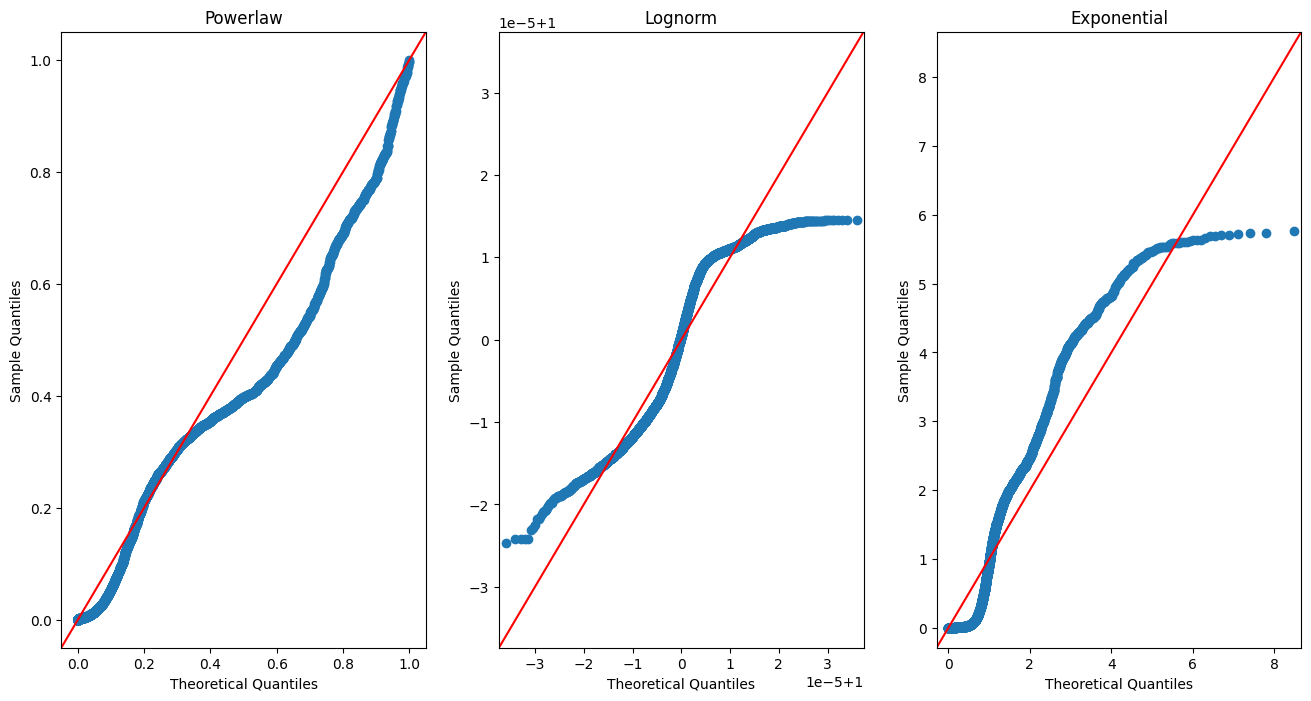

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

qqplot(temp, scipy.stats.distributions.powerlaw, line="45", fit=True, ax=ax[0])
ax[0].set_title("Powerlaw")

qqplot(np.log(temp), scipy.stats.distributions.lognorm, line="45", fit=True, ax=ax[1])
ax[1].set_title("Lognorm")

qqplot(temp, scipy.stats.distributions.expon, line="45", fit=True, ax=ax[2])
ax[2].set_title("Exponential")

if save_figs:
    plt.savefig("figures/seed_inter-event-qqplots.jpg")
plt.show()

In [29]:
# Perform Kolmogorov-Smirnov test
fit = powerlaw.Fit(xmin=temp.min(), xmax=temp.max(), data=temp)

for i, j in zip([fit.power_law.cdf, fit.lognormal.cdf, fit.exponential.cdf], ["powerlaw", "lognormal", "expon"]):
    ks_statistic, p_value = kstest(temp, i)

    print(f"{j} KS Statistic: {ks_statistic}")
    print(f"{j} P-value: {p_value}")

powerlaw KS Statistic: 0.35304341241737014
powerlaw P-value: 0.0
lognormal KS Statistic: 0.21227751112169246
lognormal P-value: 9.033628107175204e-193
expon KS Statistic: 0.3829401931052466
expon P-value: 0.0


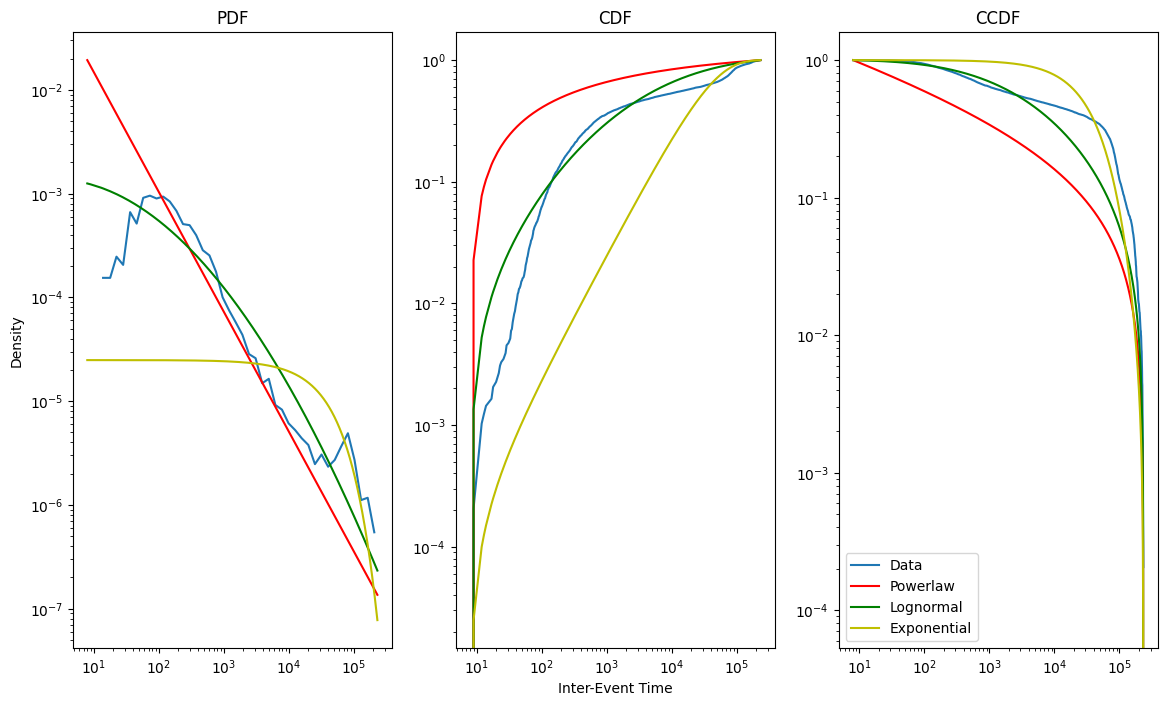

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

fit.plot_pdf(ax=axs[0])
fit.power_law.plot_pdf(color="r", ax=axs[0])
fit.lognormal.plot_pdf(color="g", ax=axs[0])
fit.exponential.plot_pdf(color="y", ax=axs[0])

fit.plot_cdf(ax=axs[1])
fit.power_law.plot_cdf(color="r", ax=axs[1])
fit.lognormal.plot_cdf(color="g", ax=axs[1])
fit.exponential.plot_cdf(color="y", ax=axs[1])

fit.plot_ccdf(ax=axs[2], label="Data")
fit.power_law.plot_ccdf(color="r", ax=axs[2], label="Powerlaw")
fit.lognormal.plot_ccdf(color="g", ax=axs[2], label="Lognormal")
fit.exponential.plot_ccdf(color="y", ax=axs[2], label="Exponential")

axs[0].set_ylabel("Density")
axs[0].set_title("PDF")

axs[1].set_xlabel("Inter-Event Time")
axs[1].set_title("CDF")

axs[2].set_title("CCDF")

plt.legend()
if save_figs:
    plt.savefig("figures/seed_inter-event-pdf.jpg")
plt.show()

In [31]:
mu = fit.lognormal.mu
sigma = fit.lognormal.sigma

print(f"Estimated mu: {mu}")
print(f"Estimated sigma: {sigma}")

Estimated mu: 8.465372775046776
Estimated sigma: 2.7585282466115832


In [32]:
# Compare power law with exponential distribution
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"power-law vs. exponential: R = {R}, p = {p}")

# Compare power law with log-normal distribution
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"power-law vs. log-normal: R = {R}, p = {p}")

power-law vs. exponential: R = 948.2483842447346, p = 2.042828217581967e-10
power-law vs. log-normal: R = -2308.4225867202226, p = 0.0


In [33]:
# Lognormal dist fits data best ()
x = 20800
cdf_value = round(scipy.stats.lognorm.sf(x, s=fit.lognormal.sigma, scale=np.exp(fit.lognormal.mu)), 3)
print(f"P(i) at {round(x/60/60, 2)}h ({x}s) is {cdf_value}")

P(i) at 5.78h (20800s) is 0.296


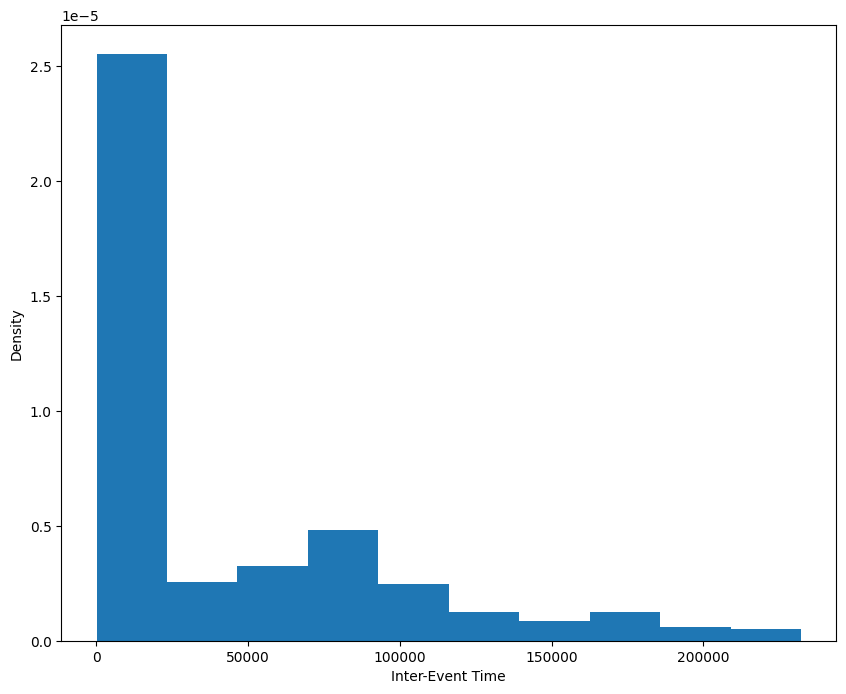

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.hist(temp, density=True)
# axs.hist(temp, density=True, bins=5468)

axs.set_xlabel("Inter-Event Time")
# axs.set_xlim(0, 10000)
axs.set_ylabel("Density")

plt.show()

***
# Merge Sim and Seed Agent Data

In [107]:
# Merge LLM Agents with their respective Seed Users
seed_sub_1_data = seed_data[seed_data["subreddit"] == "DiscussPolitics1"]

seed_sub_1_data = seed_sub_1_data[[
    "ParticipantID",
    "polinterest",
    "time_online",
    "social_media",
    "comments_online",
    "comment_count",
]]

print(len(seed_sub_1_data))

80


In [108]:
for k in list(data.keys()):
    llm_posts = {}
    for i in seed_sub_1_data["ParticipantID"]:
        user_posts = []
        for j in data[k]:
            if i == j["seed_user_id"]:
                user_posts.append(j)
    
        llm_posts[i] = user_posts

    seed_sub_1_data[k] = seed_sub_1_data["ParticipantID"].map(llm_posts)
    seed_sub_1_data[f"{k}_comment_count"] = seed_sub_1_data[k].map(len)

***
# Interaction Analysis

In [109]:
discussions_data["created_comment"] = pd.to_datetime(
    discussions_data["created_comment"]
)
discussions_data.groupby(["subreddit", "post_title"])["created_comment"].transform(
    lambda x: x.max() - x.min()
).median()

Timedelta('5 days 17:47:37')

In [110]:
# Correlation between self-reported vars and comment # for llm agents
for i in list(seed_sub_1_data.filter(regex="_comment_count").columns):
    for j in ["polinterest", "time_online", "social_media", "comments_online"]:
        corr = scipy.stats.spearmanr(seed_sub_1_data[j],
                                    seed_sub_1_data[i])
        if corr.pvalue <= 0.05:
            print(i, j, corr)

reddit-sim_dp1_qwen-18h_14-55_comment_count comments_online SignificanceResult(statistic=np.float64(0.5254753354500111), pvalue=np.float64(5.592427663749464e-07))
reddit-sim_dp1_qwen-18h_18-58_comment_count time_online SignificanceResult(statistic=np.float64(0.22406890570218327), pvalue=np.float64(0.04570856574236898))
reddit-sim_dp1_qwen-18h_18-58_comment_count comments_online SignificanceResult(statistic=np.float64(0.5123293901155671), pvalue=np.float64(1.185685693461269e-06))
reddit-sim_dp1_qwen-18h_15-30_comment_count social_media SignificanceResult(statistic=np.float64(0.2573823299058723), pvalue=np.float64(0.021175341772909858))
reddit-sim_dp1_qwen-18h_15-30_comment_count comments_online SignificanceResult(statistic=np.float64(0.5201008373589349), pvalue=np.float64(7.632883187701883e-07))
reddit-sim_dp1_qwen-18h_16-49_comment_count social_media SignificanceResult(statistic=np.float64(0.27183351331469097), pvalue=np.float64(0.014719507243276175))
reddit-sim_dp1_qwen-18h_16-49_comm

In [111]:
temp = {"stat" : [], "p" : []}
for i in list(seed_sub_1_data.filter(regex="_comment_count").columns):
    corr = scipy.stats.spearmanr(seed_sub_1_data["polinterest"],
                                seed_sub_1_data[i])
    temp["stat"].append(corr.statistic)
    temp["p"].append(corr.pvalue)

print("polinterest", pu.fisher(temp))

polinterest (np.float64(0.019995453092000667), np.float64(0.4574579946696036))


In [112]:
temp = {"stat" : [], "p" : []}
for i in list(seed_sub_1_data.filter(regex="_comment_count").columns):
    corr = scipy.stats.spearmanr(seed_sub_1_data["time_online"],
                                seed_sub_1_data[i])
    temp["stat"].append(corr.statistic)
    temp["p"].append(corr.pvalue)

print("time_online", pu.fisher(temp))

time_online (np.float64(0.17170043282884498), np.float64(3.2848602026236406e-06))


In [113]:
temp = {"stat" : [], "p" : []}
for i in list(seed_sub_1_data.filter(regex="_comment_count").columns):
    corr = scipy.stats.spearmanr(seed_sub_1_data["social_media"],
                                seed_sub_1_data[i])
    temp["stat"].append(corr.statistic)
    temp["p"].append(corr.pvalue)

print("social_media", pu.fisher(temp))

social_media (np.float64(0.14373094866081754), np.float64(0.0006696141321896887))


In [114]:
temp = {"stat" : [], "p" : []}
for i in list(seed_sub_1_data.filter(regex="_comment_count").columns):
    corr = scipy.stats.spearmanr(seed_sub_1_data["comments_online"],
                                seed_sub_1_data[i])
    temp["stat"].append(corr.statistic)
    temp["p"].append(corr.pvalue)

print("comments_online", pu.fisher(temp))

comments_online (np.float64(0.45961946868816), np.float64(0.0))


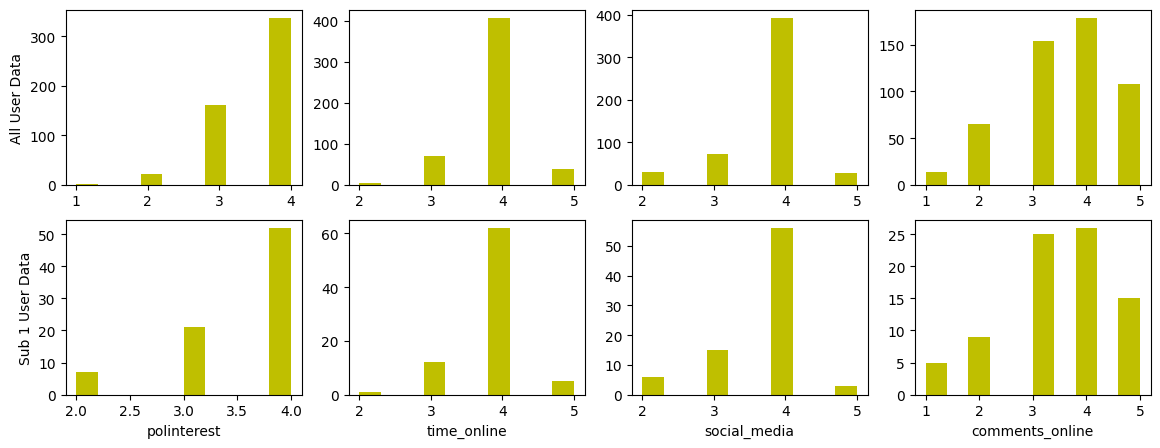

In [115]:
# Comparison of self-reported vars in whole sample vs. Sub 1
plt.rcParams['axes.prop_cycle'] = plt.cycler(color="y")
fig, axs = plt.subplots(2, 4, figsize=(14, 5))

axs[0,0].hist(seed_data["polinterest"])
axs[0,0].set_ylabel("All User Data")

axs[0,1].hist(seed_data["time_online"])

axs[0,2].hist(seed_data["social_media"])

axs[0,3].hist(seed_data["comments_online"])

axs[1,0].hist(seed_sub_1_data["polinterest"])
axs[1,0].set_xlabel("polinterest")
axs[1,0].set_ylabel("Sub 1 User Data")

axs[1,1].hist(seed_sub_1_data["time_online"])
axs[1,1].set_xlabel("time_online")

axs[1,2].hist(seed_sub_1_data["social_media"])
axs[1,2].set_xlabel("social_media")

axs[1,3].hist(seed_sub_1_data["comments_online"])
axs[1,3].set_xlabel("comments_online")

if save_figs:
    plt.savefig("figures/whole-sub1_self-reports.jpg")
plt.show()

In [116]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["polinterest"], 
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.07959907085369836), pvalue=np.float64(0.0697318497152728))

In [117]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["time_online"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(-0.06097692149655422), pvalue=np.float64(0.1650050053764535))

In [118]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["social_media"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.04920081140413537), pvalue=np.float64(0.2627438135586968))

In [119]:
# Whole sample correlation analysis
scipy.stats.spearmanr(seed_data["comments_online"],
                      seed_data["comment_count"])

SignificanceResult(statistic=np.float64(0.13399045580204383), pvalue=np.float64(0.0021992413183149007))

***
# Content Analysis

In [120]:
with open("perspective_secret.txt", "r") as f:
    api_key = f.read()

In [121]:
# j = pu.query_perspective(data[list(data.keys())[0]], api_key)

# with open("perspective_rating.json", "w") as f:
#     json.dump(j, f, indent=4)

In [122]:
with open("perspective_rating.json", "r") as f:
    responses = json.load(f)

***
# Junk yard

In [395]:
st = datetime(2025, 6, 4, 13, 00, 00)

class Clock:
    r"""Clock used for the sandbox."""

    def __init__(self, k: int = 1):
        self.real_start_time = st
        self.k = k
        self.time_step = 0

    def time_transfer(self, now_time: datetime,
                      start_time: datetime) -> datetime:
        time_diff = now_time - self.real_start_time
        adjusted_diff = self.k * time_diff
        adjusted_time = start_time + adjusted_diff
        return adjusted_time

    def get_time_step(self) -> str:
        return str(self.time_step)

class Env:
    def __init__(self):
        self.start_time = st
        self.sandbox_clock = Clock(60)

In [396]:
env = Env()

In [430]:
import sqlite3
import pandas as pd
import random
from datetime import datetime, timedelta

def activation_function(
    data,
    db_path,
    env,
    mapping_type="comments",
    print_info=True,
    initiation_ie_time=3600,
    inter_burst_time=3600*3,
    distribution_type="lognorm",
    sigma=2.759,
    mu=8.465,
    recurring_activation_prob_modifier=0.1
):
    """
    Determines the activation of LLM agents in the OASIS simulation.
    Each agent is assigned a probability of activation depending
    on the seed user's self reported online behavior.

    Parameters
    data: seed user data (contains self-reported online behavior)
        indexed by ParticipantID (seed_id)
    db_path: path to OASIS simulation data base
    """

    current_time = env.sandbox_clock.time_transfer(
                datetime.now(), env.start_time)
    
    if mapping_type == "comments":
        mapping = {
            1: 0.005,  # never
            2: 0.0075, # once per month
            3: 0.03,   # once per week
            4: 0.05,   # almost daily
            5: 0.1,    # multiple times a day
        }
    elif mapping_type == "social_media": # very high!
        mapping = {
            1: 0.01, # not at all
            2: 0.03, # a couple of times per week
            3: 0.08, # about once per day
            4: 0.12, # multiple times per day
            5: 0.15, # almost constantly
        }
    
    # Create empty list to hold IDs of activated agents
    activated_agents_step = []

    # Access content from "live" db
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # User data
    cursor.execute("SELECT user_id, user_name FROM user")

    rows = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    db_content = [dict(zip(columns, row)) for row in rows]

    # Comment data
    cursor.execute("SELECT user_id, created_at FROM comment")

    rows = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    previous_activations = [dict(zip(columns, row)) for row in rows]
    
    conn.close()

    activated_agents = {}

    for i in previous_activations:
        timestamp_str = i["created_at"]
        timestamp = datetime.fromisoformat(timestamp_str)
        if i["user_id"] not in activated_agents.keys():
            activated_agents[i["user_id"]] = [timestamp]
        else:
            activated_agents[i["user_id"]].append(timestamp)
    
    # Decide agent activation
    for i in db_content:
        i["comments_online"] = data.at[i["user_name"], "comments_online"]
        i["activation_prob"] = mapping[i["comments_online"]]
        try:
            last_initiation = activated_agents[i["user_id"]][-1]
            # print(activated_agents[i["user_id"]][::-1])
            for j in activated_agents[i["user_id"]][::-1]:
                # print("Diff:", last_initiation - j)
                if last_initiation - j <= timedelta(seconds=initiation_ie_time):
                    last_initiation = j
                else:
                    break
            i["last_initiation"] = last_initiation
        except:
            i["last_initiation"] = datetime(1970, 1, 1, 0, 0, 0)

        activation_threshold = random.random()
        if i["user_id"] not in activated_agents:
            activation_prob = i["activation_prob"] 
            i["activated"] = (
                True if activation_threshold < activation_prob else False
            )
        
        else:
            # Estimated mu: 8.465372775046776
            # Estimated sigma: 2.7585282466115832
            x = (current_time - i["last_initiation"]).total_seconds()
            recurring_activation_prob = round(
                scipy.stats.lognorm.sf(x, s=sigma, scale=np.exp(mu)),
                3
            ) * recurring_activation_prob_modifier
            activation_prob = i["activation_prob"] + recurring_activation_prob
            # print(i["activation_prob"], x, recurring_activation_prob, activation_prob)
            i["activated"] = (
                True if activation_threshold < activation_prob else False
            )
        
        if i["activated"] == True:
            activated_agents_step.append(i["user_id"])

    if print_info:
        print("#" * 20)      
        print("Activation function activated:", len(activated_agents_step), "users.")
        print("#" * 20)
    return activated_agents_step

In [449]:
activation_function(
    sample_data.set_index("ParticipantID"), 
    "../data/test_dbs/all_subs/reddit-sim_dp1_qwen-24h_00-03.db",
    env,
    recurring_activation_prob_modifier=0.2
)

####################
Activation function activated: 3 users.
####################


[39, 60, 70]

In [139]:
# Implement interaction burst dynamics
import sqlite3

db_path = "../data/test_dbs/all_subs/reddit-sim_dp1_qwen-24h_00-03.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT user_id, created_at FROM trace")

rows = cursor.fetchall()
columns = [col[0] for col in cursor.description]
comment_content = [dict(zip(columns, row)) for row in rows]

conn.close()

comment_content

[{'user_id': 0, 'created_at': '2025-06-04 00:05:55.496093'},
 {'user_id': 1, 'created_at': '2025-06-04 00:06:01.032413'},
 {'user_id': 2, 'created_at': '2025-06-04 00:06:04.982693'},
 {'user_id': 3, 'created_at': '2025-06-04 00:06:08.511293'},
 {'user_id': 4, 'created_at': '2025-06-04 00:06:12.032273'},
 {'user_id': 5, 'created_at': '2025-06-04 00:06:15.160973'},
 {'user_id': 6, 'created_at': '2025-06-04 00:06:21.287513'},
 {'user_id': 7, 'created_at': '2025-06-04 00:06:24.280913'},
 {'user_id': 8, 'created_at': '2025-06-04 00:06:29.055173'},
 {'user_id': 9, 'created_at': '2025-06-04 00:06:36.221873'},
 {'user_id': 10, 'created_at': '2025-06-04 00:06:39.944753'},
 {'user_id': 11, 'created_at': '2025-06-04 00:06:44.475353'},
 {'user_id': 12, 'created_at': '2025-06-04 00:06:48.860393'},
 {'user_id': 13, 'created_at': '2025-06-04 00:06:53.326613'},
 {'user_id': 14, 'created_at': '2025-06-04 00:06:56.597393'},
 {'user_id': 15, 'created_at': '2025-06-04 00:07:00.045713'},
 {'user_id': 16, '